## pyfkpt + CAMB: 1-loop RSD multipoles

In [1]:
# ---- imports (standard packages) ----
import os, tempfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# ---- pyfkpt (new fkpt wrapper) ----
import pyfkpt.rsd as pyfkpt
    
# ---- ISiTGR: linear matter P(k) and f at z_pk ----
import isitgr
from isitgr import model

def zpad_guard_for_single_z(z0, *, dln_a=5e-3, window=9, guard_extra=2, a_floor=1e-4):
    """
    Redshift pad that guarantees a *central* ln a window around z0.
    guard_extra adds a couple of half-steps beyond the nominal window.
    """
    import numpy as np
    w    = int(window) + (window % 2 == 0)
    half = w // 2
    a0   = 1.0/(1.0 + float(z0))
    lna0 = np.log(a0)
    # central window nodes
    offs = np.arange(-half, half+1, dtype=float) * float(dln_a)
    lnai = lna0 + offs
    # add a small guard on both sides so central window really fits
    guard = (half + int(guard_extra)) * float(dln_a)
    lnai  = np.concatenate([lnai, [lna0 - guard, lna0 + guard]])
    ai    = np.clip(np.exp(np.unique(np.sort(lnai))), a_floor, 1.0)
    return np.unique(np.sort(1.0/ai - 1.0))

# Test 1: Run pyfkpt with
### i) Regular settings: Pk gets rescaled within fkpt and growth rate is calculated internally
### ii) New settings: Pk is no rescaled but passed directly from ISiTGR consider linear MG effects, and growth rate is still calculated internally
### iii) New settings (final): ISiTGR provides linear Pk with MG effects as well as the growth rate. Fkpt then applies 1-loop corrections.

Define cosmology and nuisance parameters

In [16]:
# ---- cosmology & nuisance parameters ----
# cosmology (same as your example)
h      = 0.6711
ombh2  = 0.022
omch2  = 0.122
omnuh2 = 0.0 #0.0006442
As     = 2e-9
ns     = 0.965
z_pk   = 0.3
N_ur   = 1.0 + 2.0328
Om     = (ombh2 + omch2 + omnuh2) / (h**2)
print("Omega_m:", Om)

# k-range for CAMB
khmin, khmax, nbk = 1.0e-4, 2.0, 1000

# nuisance vector (b1, b2, bs2, b3nl, EFT, stoch, shot)
b1 = 1.70               
b2 = -0.45
bs2  = -4/7*(b1 - 1)
b3nl = 32/315*(b1 - 1)

alpha0, alpha2, alpha4, ctilde = 3.0, -29.0, 0.0, 0.0
alpha0shot, alpha2shot, pshotp = 0.08, -8.0, 5000.0

nuis = [b1,b2,bs2,b3nl,alpha0,alpha2,alpha4,ctilde,alpha0shot,alpha2shot,pshotp]

Omega_m: 0.31973340628583885


Get Pk_lin and growth rate from ISiTGR

In [3]:
# --- GR (for comparison P_lin only) ---
pars_GR = isitgr.CAMBparams()
pars_GR.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, mnu=93.14*omnuh2,
                      MG_parameterization="muSigma", mu0=0.0)
pars_GR.InitPower.set_params(As=As, ns=ns)
pars_GR.set_matter_power(redshifts=[z_pk], kmax=2.0)
pars_GR.NonLinear = model.NonLinear_none
results_GR = isitgr.get_results(pars_GR)
PK_GR, _, ks_GR = results_GR.get_matter_power_interpolator(
    nonlinear=False, hubble_units=True, k_hunit=True, return_z_k=True, silent=True
)
pk_lin_GR = PK_GR.P(z_pk, ks_GR)

# --- ISiTGR setup: MG results ---
mu0=0.5
pars = isitgr.CAMBparams()
pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, mnu=93.14*omnuh2,
                   MG_parameterization="muSigma", mu0=mu0)
pars.InitPower.set_params(As=As, ns=ns)

# finite-difference step in ln a around z_pk
dln_a = 1e-3
a0 = 1.0/(1.0 + z_pk)
a1 = a0 * np.exp(-dln_a)
a2 = a0 * np.exp(+dln_a)
z1 = 1.0/a1 - 1.0
z2 = 1.0/a2 - 1.0

# include z=0 because your f_of_k uses P(z=0,k) for normalization
z_list = sorted([z1, z_pk, z2, 0.0])
pars.set_matter_power(redshifts=z_list, kmax=2.0)
pars.NonLinear = model.NonLinear_none

# --- run ISiTGR as you already do (with z_list including z1, z_pk, z2, 0.0) ---
results = isitgr.get_results(pars)

# 1) P_lin on ISiTGR grid
PK, _, ks_pk = results.get_matter_power_interpolator(
    nonlinear=False, hubble_units=True, k_hunit=True, return_z_k=True, silent=True
)
pk_lin = PK.P(z_pk, ks_pk)        # pk only “in the m_use” via target range

# 2) f(k) on ISiTGR grid, then mask to sub-horizon
ks_fk, f_raw = results.f_of_k(z_pk, hubble_units=True, k_hunit=True,
                              dln_a=5e-3, nsteps=2, smooth_median_width=0)

kmin, kmax = 1e-3, 0.5
m_use_fk   = (ks_fk >= kmin) & (ks_fk <= kmax)
ks_use     = ks_fk[m_use_fk]
f_use      = f_raw[m_use_fk]

# 3) Choose FKPT input grid (what you’ll pass into pyfkpt)
ks = np.geomspace(kmin, kmax, 204)

# 4) Interpolate BOTH pk and f onto k_target (so grids match)
fk_lin = np.interp(ks, ks_use, f_use)
# clamp ends of fk if you like:
fk_lin[ks < ks_use.min()] = f_use[0]
fk_lin[ks > ks_use.max()] = f_use[-1]

# 5) f0 computed separately on the same target grid (your preferred large-scale band)
low_band = (ks >= 1e-3) & (ks <= 3e-3)
f0 = float(np.median(fk_lin[low_band])) if np.any(low_band) else float(fk_lin[0])

Note: redshifts have been re-sorted (earliest first)


Calculate 1-loop for LCDM + 3 variants

In [ ]:
# ==========================
# GR multipoles: using ISiTGR in the GR limit
# ==========================

# ---- pyfkpt: build FKPT tables in memory & get RSD multipoles ----
# Preferred: pass tables in-memory. If your installed pyfkpt lacks `tables=...`,
# we fall back to a TemporaryDirectory (auto-deleted).
params = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    kmin=float(max(1e-3, ks.min())), kmax=min(float(ks.max()), 0.5),
    Nk=min(ks.size, 240),
    nquadSteps=300, chatty=0, model="LCDM", fR0=1e-15,
)

# compute FKPT tables (no files)
tables = pyfkpt.compute_multipoles(k=ks_GR, pk=pk_lin_GR, **params)

# evaluate multipoles (ℓ=0,2,4) without AP
k_eval = np.asarray(tables["k"], float)
k_eval = k_eval[(k_eval > 0) & (k_eval <= params["kmax"])]

k_GR, P0_GR, P2_GR, P4_GR = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables)

print("GR done")

# ==========================
# MG multipoles: three variants
# ==========================

# Base FKPT params (shared)
base = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    kmin=float(max(1e-3, ks.min())),
    kmax=float(min(ks.max(), 0.5)),
    Nk=int(min(ks.size, 240)),
    nquadSteps=300, chatty=0,
    model="HDKI",    # must match models.c
    mg_variant="mu_OmDE",
    mu0=mu0
)

# -------------------------
# (1) MG (rescaled PS, internal f)
# -------------------------
p1 = deepcopy(base); p1["rescale_PS"] = True; p1["use_beyond_eds_kernels"] = True
tables_MG_internal = pyfkpt.compute_multipoles(k=ks_GR, pk=pk_lin_GR, **p1)
k_MG_internal, P0_MG_internal, P2_MG_internal, P4_MG_internal = pyfkpt.rsd_multipoles(
    k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables_MG_internal
)
print("MG1 variant done")

# evaluation grid
k_eval = np.linspace(base["kmin"], base["kmax"], base["Nk"])

# -------------------------
# (2) MG (unrescaled PS, internal f)
# -------------------------
p2 = deepcopy(base); p2["rescale_PS"] = False; p2["use_beyond_eds_kernels"] = True
tables_MG_unrescaled = pyfkpt.compute_multipoles(k=ks_pk, pk=pk_lin, **p2)
k_MG_unrescaled, P0_MG_unrescaled, P2_MG_unrescaled, P4_MG_unrescaled = pyfkpt.rsd_multipoles(
    k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables_MG_unrescaled
)

print("MG2 variant done")

# -------------------------
# (3) MG (unrescaled PS, external f from ISiTGR)
# -------------------------
p3 = deepcopy(base); p3["rescale_PS"] = False; p3["use_beyond_eds_kernels"] = True
tables_MG = pyfkpt.compute_multipoles(k=ks_pk, pk=pk_lin, fk=f_raw, f0=f0, **p3)
k_MG, P0_MG, P2_MG, P4_MG = pyfkpt.rsd_multipoles(
    k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables_MG
)

print("MG3 variant done")

GR done
MG1 variant done
MG2 variant done
MG3 variant done


Plotting

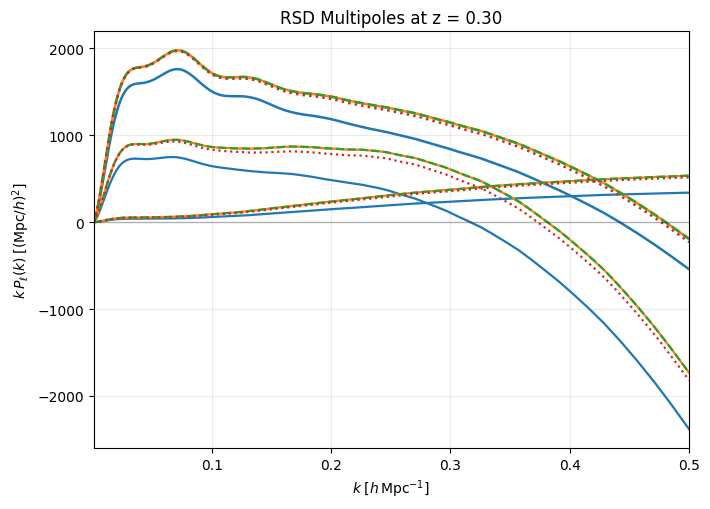

In [11]:
# ==========================
# Plot multipoles for GR + 3 MG variants
# ==========================
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

series = [
    ("GR",                  "C0", "-",  k_GR,            P0_GR,            P2_GR,            P4_GR),
    ("MG (rescaled PS), $\mu(a)=1+\mu_0\Omega_\mathrm{DE}(a)$",    "C1", "-",  k_MG_internal,   P0_MG_internal,   P2_MG_internal,   P4_MG_internal),
    ("MG (unrescaled PS), $\mu(a)=1+\mu_0\Omega_\mathrm{DE}(a)$",  "C2", "--", k_MG_unrescaled, P0_MG_unrescaled, P2_MG_unrescaled, P4_MG_unrescaled),
    ("MG (external f(k)), $\mu(a)=1+\mu_0\Omega_\mathrm{DE}(a)$",  "C3", ":",  k_MG,            P0_MG,            P2_MG,            P4_MG),
]

fig, ax = plt.subplots(figsize=(7.2, 5.2))

# plot: same style per scenario; label only once per scenario
for label, color, ls, kk, P0, P2, P4 in series:
    ax.plot(kk, kk*P0, linestyle=ls, color=color, linewidth=1.8, label=label)  # ℓ=0 (carries legend label)
    ax.plot(kk, kk*P2, linestyle=ls, color=color, linewidth=1.6)               # ℓ=2
    ax.plot(kk, kk*P4, linestyle=ls, color=color, linewidth=1.6)               # ℓ=4

# legend: scenarios only
#ax.legend(title="Scenario", loc="best")

ax.set_xlabel(r"$k\;[h\,\mathrm{Mpc}^{-1}]$")
ax.set_ylabel(r"$k\,P_\ell(k)\;[(\mathrm{Mpc}/h)^2]$")
ax.set_title(f"RSD Multipoles at z = {z_pk:.2f}")

ax.set_xlim(base["kmin"], base["kmax"])
ax.axhline(0, color='k', alpha=0.25, lw=1.0)

# ax.set_xscale('log')  # optional
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3288582/2292050463.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


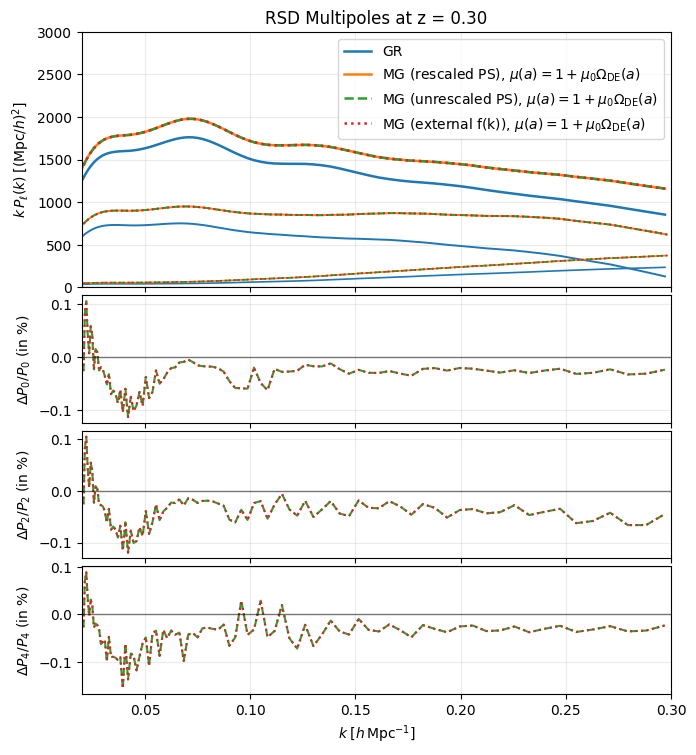

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# show only 0 < k < 0.02
kmin_plot = 0.02           # or float(base.get("kmin", 0.0))
kmax_plot = 0.3

series = [
    ("GR",                  "C0", "-",  k_GR,            P0_GR,            P2_GR,            P4_GR),
    ("MG (rescaled PS), $\\mu(a)=1+\\mu_0\\Omega_\\mathrm{DE}(a)$",
                            "C1", "-",  k_MG_internal,   P0_MG_internal,   P2_MG_internal,   P4_MG_internal),
    ("MG (unrescaled PS), $\\mu(a)=1+\\mu_0\\Omega_\\mathrm{DE}(a)$",
                            "C2", "--", k_MG_unrescaled, P0_MG_unrescaled, P2_MG_unrescaled, P4_MG_unrescaled),
    ("MG (external f(k)), $\\mu(a)=1+\\mu_0\\Omega_\\mathrm{DE}(a)$",
                            "C3", ":",  k_MG,            P0_MG,            P2_MG,            P4_MG),
]

def mask_window(kk, *ys):
    m = (kk > kmin_plot) & (kk < kmax_plot)
    out = [kk[m]]
    for y in ys: out.append(y[m])
    return out if len(out) > 2 else out[0]

def _interp_common(x_ref, x_src, y_src):
    xmin = max(x_ref.min(), x_src.min())
    xmax = min(x_ref.max(), x_src.max())
    mask = (x_ref >= xmin) & (x_ref <= xmax)
    y_ref = np.full_like(x_ref, np.nan, dtype=float)
    if np.count_nonzero(mask):
        y_ref[mask] = np.interp(x_ref[mask], x_src, y_src)
    return y_ref, mask

def _safe_rel(num, den, m):
    mm = m & np.isfinite(num) & np.isfinite(den) & (den != 0.0)
    out = np.full_like(num, np.nan)
    out[mm] = num[mm] / den[mm] - 1.0
    return out*100

# mask everything to 0 < k < 0.02
series_masked = []
for label, color, ls, kk, P0, P2, P4 in series:
    km, P0m, P2m, P4m = mask_window(kk, P0, P2, P4)
    series_masked.append((label, color, ls, km, P0m, P2m, P4m))

# reference = rescaled MG
k_ref   = series_masked[1][3]
P0_ref  = series_masked[1][4]; P2_ref = series_masked[1][5]; P4_ref = series_masked[1][6]
# unrescaled + external
_, _, _, k_unr, P0_unr, P2_unr, P4_unr = series_masked[2]
_, _, _, k_ext, P0_ext, P2_ext, P4_ext = series_masked[3]

# interpolate onto k_ref (within the same masked window)
P0_unr_i, m0a = _interp_common(k_ref, k_unr, P0_unr)
P2_unr_i, m2a = _interp_common(k_ref, k_unr, P2_unr)
P4_unr_i, m4a = _interp_common(k_ref, k_unr, P4_unr)
P0_ext_i, m0b = _interp_common(k_ref, k_ext, P0_ext)
P2_ext_i, m2b = _interp_common(k_ref, k_ext, P2_ext)
P4_ext_i, m4b = _interp_common(k_ref, k_ext, P4_ext)

rel0_unr = _safe_rel(P0_ref, P0_unr_i, m0a)
rel2_unr = _safe_rel(P2_ref, P2_unr_i, m2a)
rel4_unr = _safe_rel(P4_ref, P4_unr_i, m4a)
rel0_ext = _safe_rel(P0_ref, P0_ext_i, m0b)
rel2_ext = _safe_rel(P2_ref, P2_ext_i, m2b)
rel4_ext = _safe_rel(P4_ref, P4_ext_i, m4b)

# plot
fig, axes = plt.subplots(4, 1, figsize=(7.6, 8.6), sharex=True,
                         gridspec_kw={"height_ratios": [2, 1, 1, 1], "hspace": 0.05})
ax_main, ax_r0, ax_r2, ax_r4 = axes

for label, color, ls, kk, P0, P2, P4 in series_masked:
    ax_main.plot(kk, kk*P0, linestyle=ls, color=color, linewidth=1.8, label=label)
    ax_main.plot(kk, kk*P2, linestyle=ls, color=color, linewidth=1.4)
    ax_main.plot(kk, kk*P4, linestyle=ls, color=color, linewidth=1.2)

ax_main.set_ylabel(r"$k\,P_\ell(k)\;[(\mathrm{Mpc}/h)^2]$")
ax_main.set_title(f"RSD Multipoles at z = {z_pk:.2f}")
ax_main.axhline(0, color='k', alpha=0.25, lw=1.0)
ax_main.grid(True, alpha=0.25)
ax_main.legend(loc="best")
ax_main.set_xlim(kmin_plot, kmax_plot)
ax_main.set_ylim(0, 3000)

def _decorate(ax, lab):
    ax.axhline(0.0, color='k', lw=1.0, alpha=0.5)
    ax.grid(True, alpha=0.25)
    ax.set_ylabel(lab)

ax_r0.plot(k_ref, rel0_unr, linestyle="--", color="C2", label="rescaled / unrescaled − 1")
ax_r0.plot(k_ref, rel0_ext, linestyle=":",  color="C3", label="rescaled / external f(k) − 1")
_decorate(ax_r0, r"$\Delta P_0/P_0$ (in %)")

ax_r2.plot(k_ref, rel2_unr, linestyle="--", color="C2")
ax_r2.plot(k_ref, rel2_ext, linestyle=":",  color="C3")
_decorate(ax_r2, r"$\Delta P_2/P_2$ (in %)")

ax_r4.plot(k_ref, rel4_unr, linestyle="--", color="C2")
ax_r4.plot(k_ref, rel4_ext, linestyle=":",  color="C3")
_decorate(ax_r4, r"$\Delta P_4/P_4$ (in %)")

ax_r4.set_xlabel(r"$k\;[h\,\mathrm{Mpc}^{-1}]$")

plt.tight_layout()
plt.show()

/tmp/ipykernel_1233300/1186523072.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


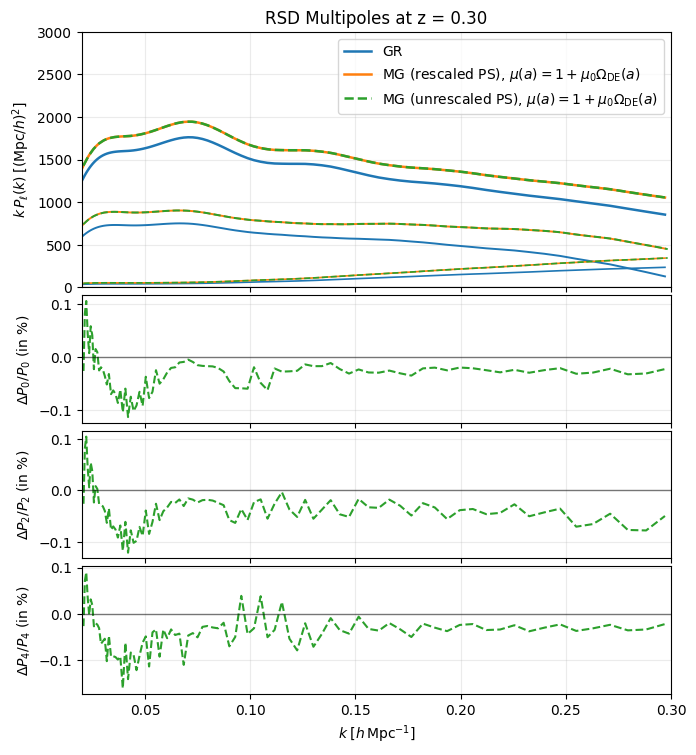

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# show only 0 < k < 0.02
kmin_plot = 0.02
kmax_plot = 0.3

series = [
    ("GR",                  "C0", "-",  k_GR,            P0_GR,            P2_GR,            P4_GR),
    ("MG (rescaled PS), $\\mu(a)=1+\\mu_0\\Omega_\\mathrm{DE}(a)$",
                            "C1", "-",  k_MG_internal,   P0_MG_internal,   P2_MG_internal,   P4_MG_internal),
    ("MG (unrescaled PS), $\\mu(a)=1+\\mu_0\\Omega_\\mathrm{DE}(a)$",
                            "C2", "--", k_MG_unrescaled, P0_MG_unrescaled, P2_MG_unrescaled, P4_MG_unrescaled),
    # (removed) ("MG (external f(k))", "C3", ":",  k_MG, P0_MG, P2_MG, P4_MG),
]

def mask_window(kk, *ys):
    m = (kk > kmin_plot) & (kk < kmax_plot)
    out = [kk[m]]
    for y in ys: out.append(y[m])
    return out if len(out) > 2 else out[0]

def _interp_common(x_ref, x_src, y_src):
    xmin = max(x_ref.min(), x_src.min())
    xmax = min(x_ref.max(), x_src.max())
    mask = (x_ref >= xmin) & (x_ref <= xmax)
    y_ref = np.full_like(x_ref, np.nan, dtype=float)
    if np.count_nonzero(mask):
        y_ref[mask] = np.interp(x_ref[mask], x_src, y_src)
    return y_ref, mask

def _safe_rel(num, den, m):
    mm = m & np.isfinite(num) & np.isfinite(den) & (den != 0.0)
    out = np.full_like(num, np.nan)
    out[mm] = num[mm] / den[mm] - 1.0
    return out * 100.0

# mask all series
series_masked = []
for label, color, ls, kk, P0, P2, P4 in series:
    km, P0m, P2m, P4m = mask_window(kk, P0, P2, P4)
    series_masked.append((label, color, ls, km, P0m, P2m, P4m))

# reference = rescaled MG
k_ref   = series_masked[1][3]
P0_ref  = series_masked[1][4]; P2_ref = series_masked[1][5]; P4_ref = series_masked[1][6]
# unrescaled only
_, _, _, k_unr, P0_unr, P2_unr, P4_unr = series_masked[2]

# interpolate unrescaled onto k_ref
P0_unr_i, m0a = _interp_common(k_ref, k_unr, P0_unr)
P2_unr_i, m2a = _interp_common(k_ref, k_unr, P2_unr)
P4_unr_i, m4a = _interp_common(k_ref, k_unr, P4_unr)

# relative diffs: rescaled / unrescaled - 1
rel0_unr = _safe_rel(P0_ref, P0_unr_i, m0a)
rel2_unr = _safe_rel(P2_ref, P2_unr_i, m2a)
rel4_unr = _safe_rel(P4_ref, P4_unr_i, m4a)

# plot
fig, axes = plt.subplots(4, 1, figsize=(7.6, 8.6), sharex=True,
                         gridspec_kw={"height_ratios": [2, 1, 1, 1], "hspace": 0.05})
ax_main, ax_r0, ax_r2, ax_r4 = axes

for label, color, ls, kk, P0, P2, P4 in series_masked:
    ax_main.plot(kk, kk*P0, linestyle=ls, color=color, linewidth=1.8, label=label)
    ax_main.plot(kk, kk*P2, linestyle=ls, color=color, linewidth=1.4)
    ax_main.plot(kk, kk*P4, linestyle=ls, color=color, linewidth=1.2)

ax_main.set_ylabel(r"$k\,P_\ell(k)\;[(\mathrm{Mpc}/h)^2]$")
ax_main.set_title(f"RSD Multipoles at z = {z_pk:.2f}")
ax_main.axhline(0, color='k', alpha=0.25, lw=1.0)
ax_main.grid(True, alpha=0.25)
ax_main.legend(loc="best")
ax_main.set_xlim(kmin_plot, kmax_plot)
ax_main.set_ylim(0, 3000)

def _decorate(ax, lab):
    ax.axhline(0.0, color='k', lw=1.0, alpha=0.5)
    ax.grid(True, alpha=0.25)
    ax.set_ylabel(lab)

ax_r0.plot(k_ref, rel0_unr, linestyle="--", color="C2", label="rescaled / unrescaled − 1")
_decorate(ax_r0, r"$\Delta P_0/P_0$ (in %)")

ax_r2.plot(k_ref, rel2_unr, linestyle="--", color="C2")
_decorate(ax_r2, r"$\Delta P_2/P_2$ (in %)")

ax_r4.plot(k_ref, rel4_unr, linestyle="--", color="C2")
_decorate(ax_r4, r"$\Delta P_4/P_4$ (in %)")

ax_r4.set_xlabel(r"$k\;[h\,\mathrm{Mpc}^{-1}]$")

plt.tight_layout()
plt.show()

# Test 2: Verify results agree in the GR limit

In [4]:
# --- ISiTGR setup: cosmology + redshift grid for finite-difference f(k,z) ---
pars = isitgr.CAMBparams()
pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, mnu=93.14*omnuh2,
                   MG_parameterization="muSigma", mu0=0.0)
pars.InitPower.set_params(As=As, ns=ns)

# finite-difference step in ln a around z_pk
dln_a = 1e-3
a0 = 1.0/(1.0 + z_pk)
a1 = a0 * np.exp(-dln_a)
a2 = a0 * np.exp(+dln_a)
z1 = 1.0/a1 - 1.0
z2 = 1.0/a2 - 1.0

# include z=0 because your f_of_k uses P(z=0,k) for normalization
z_list = sorted([z1, z_pk, z2, 0.0])
pars.set_matter_power(redshifts=z_list, kmax=2.0)
pars.NonLinear = model.NonLinear_none

# --- run ISiTGR as you already do (with z_list including z1, z_pk, z2, 0.0) ---
results = isitgr.get_results(pars)

# 1) Use the cached interpolator to get the internal k-grid and P_lin(k,z_pk)
PK, z_nodes, ks = results.get_matter_power_interpolator(
    nonlinear=False, hubble_units=True, k_hunit=True, return_z_k=True, silent=True
)
pk_lin = PK.P(z_pk, ks)        # shape (nk_internal,)

# 2) f(k,z_pk) uses the same internal k-grid (ks)
kh_fk, fk_lin = results.f_of_k(z_pk, hubble_units=True, k_hunit=True)
# sanity: these should now match exactly
assert np.allclose(kh_fk, ks)

# 3) large-scale limit f0 (choose your small-k cut)
smallk = ks < 3e-3
f0 = float(np.mean(fk_lin[smallk])) if np.any(smallk) else float(fk_lin[0])

Note: redshifts have been re-sorted (earliest first)


In [ ]:
# ==========================
# GR multipoles: using ISiTGR in the GR limit
# ==========================

# ---- pyfkpt: build FKPT tables in memory & get RSD multipoles ----
# Preferred: pass tables in-memory. If your installed pyfkpt lacks `tables=...`,
# we fall back to a TemporaryDirectory (auto-deleted).
params = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    kmin=float(max(1e-3, ks.min())), kmax=min(float(ks.max()), 0.5),
    Nk=min(ks.size, 240),
    nquadSteps=300, chatty=0, model="LCDM", fR0=1e-15,
)

# compute FKPT tables (no files)
tables = pyfkpt.compute_multipoles(k=ks, pk=pk_lin, **params)

# evaluate multipoles (ℓ=0,2,4) without AP
k_eval = np.asarray(tables["k"], float)
k_eval = k_eval[(k_eval > 0) & (k_eval <= params["kmax"])]

k_GR, P0_GR, P2_GR, P4_GR = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables)

print("GR done")

# ==========================
# MG multipoles: three variants
# ==========================

# Base FKPT params (shared)
base = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    kmin=float(max(1e-3, ks.min())),
    kmax=float(min(ks.max(), 0.5)),
    Nk=int(min(ks.size, 240)),
    nquadSteps=300, chatty=0,
    model="HDKI",    # must match models.c
    mg_variant="mu_OmDE",
    mu0=0.1
)

# evaluation grid
k_eval = np.linspace(base["kmin"], base["kmax"], base["Nk"])

# -------------------------
# (3) MG (unrescaled PS, external f from ISiTGR)
# -------------------------
p_GR_limit = deepcopy(base); p_GR_limit["rescale_PS"] = True
tables_MG = pyfkpt.compute_multipoles(k=ks, pk=pk_lin, **p_GR_limit)
k_MG, P0_MG, P2_MG, P4_MG = pyfkpt.rsd_multipoles(
    k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables_MG
)

GR done


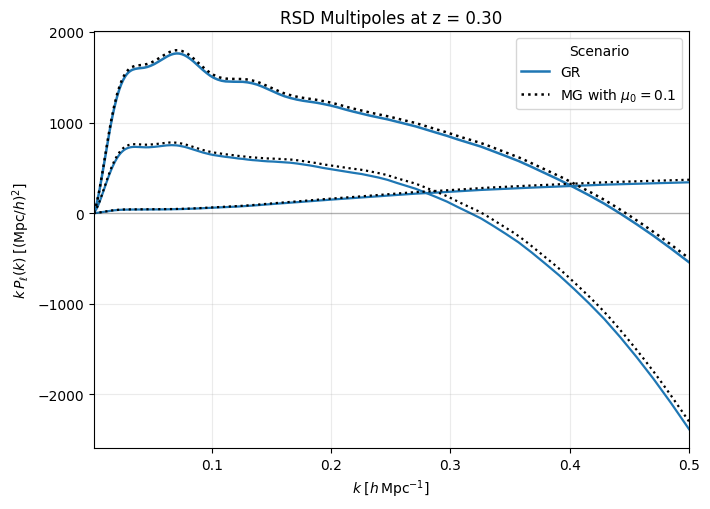

In [11]:
# ==========================
# Plot multipoles for GR + 3 MG variants
# ==========================
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

series = [
    ("GR",                  "C0", "-",  k_GR,            P0_GR,            P2_GR,            P4_GR),
    ("MG with $\mu_0=0.1$",  "k", ":",  k_MG,            P0_MG,            P2_MG,            P4_MG),
]

fig, ax = plt.subplots(figsize=(7.2, 5.2))

# plot: same style per scenario; label only once per scenario
for label, color, ls, kk, P0, P2, P4 in series:
    ax.plot(kk, kk*P0, linestyle=ls, color=color, linewidth=1.8, label=label)  # ℓ=0 (carries legend label)
    ax.plot(kk, kk*P2, linestyle=ls, color=color, linewidth=1.6)               # ℓ=2
    ax.plot(kk, kk*P4, linestyle=ls, color=color, linewidth=1.6)               # ℓ=4

# legend: scenarios only
ax.legend(title="Scenario", loc="best")

ax.set_xlabel(r"$k\;[h\,\mathrm{Mpc}^{-1}]$")
ax.set_ylabel(r"$k\,P_\ell(k)\;[(\mathrm{Mpc}/h)^2]$")
ax.set_title(f"RSD Multipoles at z = {z_pk:.2f}")

ax.set_xlim(base["kmin"], base["kmax"])
ax.axhline(0, color='k', alpha=0.25, lw=1.0)

# ax.set_xscale('log')  # optional
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# Test 3: Test $\mu(a) = 1 + \mu_0 \Omega_\mathrm{DE}(a)$ with and withouth EdS kernels

In [ ]:
# ---- imports (standard packages) ----
import os, tempfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# ---- pyfkpt (new fkpt wrapper) ----
import pyfkpt.rsd as pyfkpt
    
# ---- ISiTGR: linear matter P(k) and f at z_pk ----
import isitgr
from isitgr import model


# ---- cosmology & nuisance parameters ----
# cosmology (same as your example)
h      = 0.6711
ombh2  = 0.022
omch2  = 0.122
omnuh2 = 0.0 #0.0006442
As     = 2e-9
ns     = 0.965
z_pk   = 0.3
N_ur   = 1.0 + 2.0328
Om     = (ombh2 + omch2 + omnuh2) / (h**2)
print("Omega_m:", Om)

# k-range for CAMB
khmin, khmax, nbk = 1.0e-4, 2.0, 1000

# nuisance vector (b1, b2, bs2, b3nl, EFT, stoch, shot)
b1 = 1.70               
b2 = -0.45
bs2  = -4/7*(b1 - 1)
b3nl = 32/315*(b1 - 1)

alpha0, alpha2, alpha4, ctilde = 3.0, -29.0, 0.0, 0.0
alpha0shot, alpha2shot, pshotp = 0.08, -8.0, 5000.0

nuis = [b1,b2,bs2,b3nl,alpha0,alpha2,alpha4,ctilde,alpha0shot,alpha2shot,pshotp]

# --- ISiTGR setup: MG results ---
mu0=0.5
pars = isitgr.CAMBparams()
pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, mnu=93.14*omnuh2,
                   MG_parameterization="muSigma", mu0=)
pars.InitPower.set_params(As=As, ns=ns)

# finite-difference step in ln a around z_pk
dln_a = 1e-3
a0 = 1.0/(1.0 + z_pk)
a1 = a0 * np.exp(-dln_a)
a2 = a0 * np.exp(+dln_a)
z1 = 1.0/a1 - 1.0
z2 = 1.0/a2 - 1.0

# include z=0 because your f_of_k uses P(z=0,k) for normalization
z_list = sorted([z1, z_pk, z2, 0.0])
pars.set_matter_power(redshifts=z_list, kmax=2.0)
pars.NonLinear = model.NonLinear_none

# --- run ISiTGR as you already do (with z_list including z1, z_pk, z2, 0.0) ---
results = isitgr.get_results(pars)

# 1) Use the cached interpolator to get the internal k-grid and P_lin(k,z_pk)
PK, _, ks = results.get_matter_power_interpolator(
    nonlinear=False, hubble_units=True, k_hunit=True, return_z_k=True, silent=True
)
pk_lin = PK.P(z_pk, ks)        # shape (nk_internal,)

# 2) f(k,z_pk) uses the same internal k-grid (ks)
kh_fk, fk_lin = results.f_of_k(z_pk, hubble_units=True, k_hunit=True)
# sanity: these should now match exactly
assert np.allclose(kh_fk, ks)

# 3) large-scale limit f0 (choose your small-k cut)
smallk = ks < 3e-3
f0 = float(np.mean(fk_lin[smallk])) if np.any(smallk) else float(fk_lin[0])

# --- cap k to 0.3 h/Mpc everywhere ---
KMAX = 0.5

# restrict to k <= 0.3
mask = ks <= KMAX
ks_cut   = ks[mask]
pk_cut   = pk_lin[mask]
fk_cut   = fk_lin[mask]

# large-scale limit f0 computed on the cut grid (unchanged logic)
smallk = ks_cut < 3e-3
f0 = float(np.mean(fk_cut[smallk])) if np.any(smallk) else float(fk_cut[0])

# Base FKPT params (share)
base = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    kmin=float(max(1e-3, ks_cut.min())),
    kmax=float(min(ks_cut.max(), KMAX)),
    Nk=int(min(ks_cut.size, 240)),
    nquadSteps=300, chatty=0,
    model="HDKI",
    mg_variant="mu_OmDE",
    mu0=mu0,
)

# evaluation grid stays within [kmin, 0.3]
k_eval = np.linspace(base["kmin"], base["kmax"], base["Nk"])

# ==========================
# (4) MG (unrescaled PS, external f(k), EdS kernels)
# ==========================
p_EdS = deepcopy(base)
p_EdS["rescale_PS"] = False
p_EdS["use_beyond_eds_kernels"] = False
tables_MG_EdS = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **p_EdS)
k_MG_EdS, P0_MG_EdS, P2_MG_EdS, P4_MG_EdS = pyfkpt.rsd_multipoles(
    k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables_MG_EdS
)

# ==========================
# (5) MG (unrescaled PS, external f(k), beyond-EdS kernels)
# ==========================
p_bEdS = deepcopy(base)
p_bEdS["rescale_PS"] = False
p_bEdS["use_beyond_eds_kernels"] = True
tables_MG_beyond = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **p_bEdS)
k_MG_beyond, P0_MG_beyond, P2_MG_beyond, P4_MG_beyond = pyfkpt.rsd_multipoles(
    k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables_MG_beyond
)

Omega_m: 0.31973340628583885
Note: redshifts have been re-sorted (earliest first)


/tmp/ipykernel_1986315/840521376.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


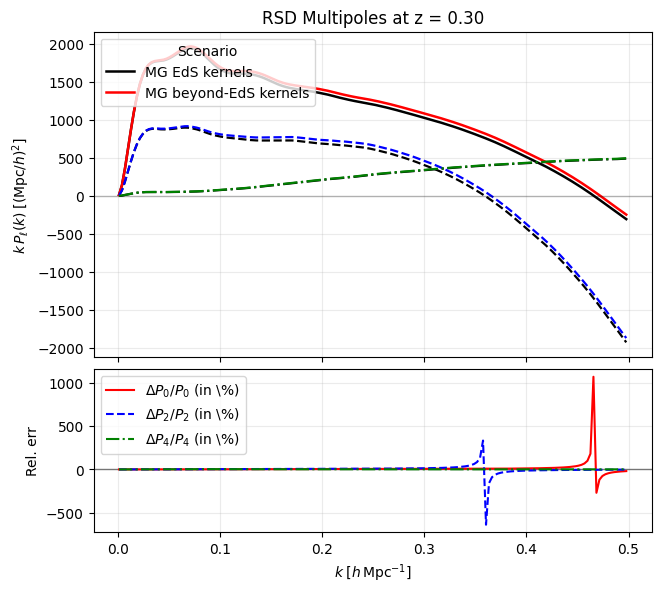

In [6]:
# ==========================
# Plot multipoles for GR + EdS vs beyond-EdS MG
# ==========================

series = [
    ("MG EdS kernels",        "k", "-",  k_MG_EdS,    P0_MG_EdS,    P2_MG_EdS,    P4_MG_EdS),
    ("MG beyond-EdS kernels", "r", "--", k_MG_beyond, P0_MG_beyond, P2_MG_beyond, P4_MG_beyond),
]

# Use EdS as reference for relative error
ref_P0 = P0_MG_EdS
ref_P2 = P2_MG_EdS
ref_P4 = P4_MG_EdS
ref_k  = k_MG_EdS

# Compute relative errors for beyond-EdS
rel_err_0 = (P0_MG_beyond - ref_P0) / ref_P0 * 100
rel_err_2 = (P2_MG_beyond - ref_P2) / ref_P2 * 100
rel_err_4 = (P4_MG_beyond - ref_P4) / ref_P4 * 100

fig, (ax_main, ax_sub) = plt.subplots(
    2, 1, figsize=(7.2, 6.5), sharex=True,
    gridspec_kw={"height_ratios": [2, 1], "hspace": 0.05}
)

# ======================
# Main panel
# ======================
for label, color, ls, kk, P0, P2, P4 in series:
    # monopole
    ax_main.plot(kk, kk*P0, linestyle='-', color='red' if 'beyond' in label else 'k',
                 linewidth=1.8, label=label)
    # quadrupole
    ax_main.plot(kk, kk*P2, linestyle='--', color='blue' if 'beyond' in label else 'k',
                 linewidth=1.6)
    # hexadecapole
    ax_main.plot(kk, kk*P4, linestyle='-.', color='green' if 'beyond' in label else 'k',
                 linewidth=1.6)

ax_main.legend(title="Scenario", loc="upper left")
ax_main.set_ylabel(r"$k\,P_\ell(k)\;[(\mathrm{Mpc}/h)^2]$")
ax_main.set_title(f"RSD Multipoles at z = {z_pk:.2f}")
ax_main.axhline(0, color='k', alpha=0.25, lw=1.0)
ax_main.grid(True, alpha=0.25)
#ax_main.set_xlim(base["kmin"], 0.2)

# ======================
# Lower subpanel (relative errors)
# ======================
ax_sub.axhline(0, color='k', lw=1.0, alpha=0.5)
ax_sub.plot(ref_k, rel_err_0, 'r-',  label=r"$\Delta P_0/P_0$ (in \%)")
ax_sub.plot(ref_k, rel_err_2, 'b--', label=r"$\Delta P_2/P_2$ (in \%)")
ax_sub.plot(ref_k, rel_err_4, 'g-.', label=r"$\Delta P_4/P_4$ (in \%)")
ax_sub.set_xlabel(r"$k\;[h\,\mathrm{Mpc}^{-1}]$")
ax_sub.set_ylabel("Rel. err")
ax_sub.grid(True, alpha=0.25)
ax_sub.legend(loc="upper left")

plt.tight_layout()
plt.show()

Omega_m: 0.31973340628583885
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


/tmp/ipykernel_1428028/3679342330.py:199: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


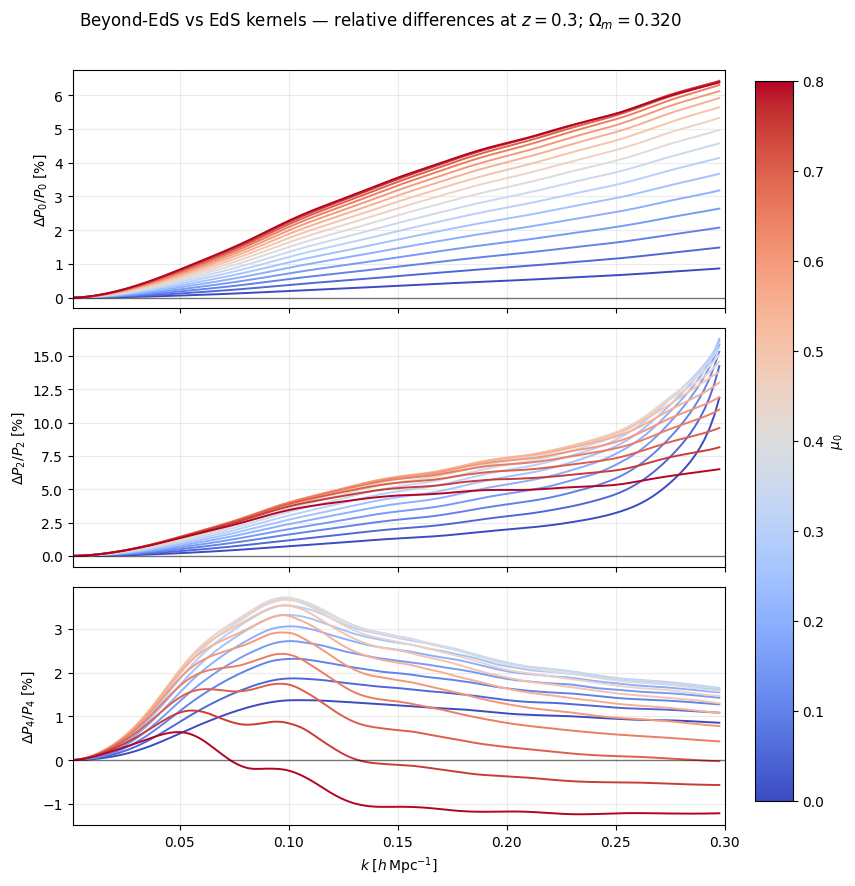

In [1]:
%matplotlib inline
# ---- imports ----
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy

# ---- pyfkpt (new fkpt wrapper) ----
import pyfkpt.rsd as pyfkpt

# ---- ISiTGR: linear matter P(k) and f at z_pk ----
import isitgr
from isitgr import model

# ==========================
# Configuration
# ==========================
# cosmology
h      = 0.6711
ombh2  = 0.022
omch2  = 0.122
omnuh2 = 0.0
As     = 2e-9
ns     = 0.965
z_pk   = 0.3

Om     = (ombh2 + omch2 + omnuh2) / (h**2)
print("Omega_m:", Om)

# target max k for FKPT evaluation
KMAX = 0.3

# how far ISiTGR/CAMB should go: at least ~16*KMAX (plus margin)
CAMB_KMAX = max(2.0, 16.0 * KMAX) * 1.25

# nuisance / bias vector (same as your example)
b1 = 1.70
b2 = -0.45
bs2  = -4/7*(b1 - 1)
b3nl = 32/315*(b1 - 1)
alpha0, alpha2, alpha4, ctilde = 3.0, -29.0, 0.0, 0.0
alpha0shot, alpha2shot, pshotp = 0.08, -8.0, 5000.0
nuis = [b1,b2,bs2,b3nl,alpha0,alpha2,alpha4,ctilde,alpha0shot,alpha2shot,pshotp]

# mu0 grid
mu0_vals = np.linspace(0.0, 0.8, 17)  # step 0.05; adjust as you wish

# base FKPT dict fields that don't change across mu0
base_common = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    nquadSteps=300, chatty=0,
    model="HDKI",
    mg_variant="mu_OmDE",
)

# ==========================
# Helper: run one mu0 and return k and relative errors
# ==========================
def rel_errors_for_mu0(mu0):
    # --- set up ISiTGR ---
    pars = isitgr.CAMBparams()
    pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, mnu=93.14*omnuh2,
                       MG_parameterization="muSigma", mu0=mu0)
    pars.InitPower.set_params(As=As, ns=ns)

    # finite-difference step in ln a around z_pk
    dln_a = 1e-3
    a0 = 1.0/(1.0 + z_pk)
    a1 = a0 * np.exp(-dln_a)
    a2 = a0 * np.exp(+dln_a)
    z1 = 1.0/a1 - 1.0
    z2 = 1.0/a2 - 1.0

    # include z=0 because f_of_k uses P(z=0,k) for normalization
    z_list = sorted([z1, z_pk, z2, 0.0])
    pars.set_matter_power(redshifts=z_list, kmax=CAMB_KMAX)
    pars.NonLinear = model.NonLinear_none

    # --- run ISiTGR ---
    results = isitgr.get_results(pars)

    # internal k-grid & P_lin(k,z_pk)
    PK, _, ks = results.get_matter_power_interpolator(
        nonlinear=False, hubble_units=True, k_hunit=True, return_z_k=True, silent=True
    )
    pk_lin = PK.P(z_pk, ks)

    # f(k,z_pk) on same grid
    kh_fk, fk_lin = results.f_of_k(z_pk, hubble_units=True, k_hunit=True)
    assert np.allclose(kh_fk, ks)

    # large-scale limit f0 (use small-k average or first point)
    smallk = ks < 3e-3
    f0 = float(np.mean(fk_lin[smallk])) if np.any(smallk) else float(fk_lin[0])

    # cut to KMAX
    mask   = ks <= KMAX
    ks_cut = ks[mask]
    pk_cut = pk_lin[mask]
    fk_cut = fk_lin[mask]

    # recompute f0 on the cut grid (keeps logic consistent)
    smallk_cut = ks_cut < 3e-3
    f0 = float(np.mean(fk_cut[smallk_cut])) if np.any(smallk_cut) else float(fk_cut[0])

    # FKPT base for this mu0
    base = dict(
        **base_common,
        mu0=mu0,
        kmin=float(max(1e-3, ks_cut.min())),
        kmax=float(min(ks_cut.max(), KMAX)),
        Nk=int(min(ks_cut.size, 240)),
    )

    # evaluation grid (ensure outputs align)
    k_eval = np.linspace(base["kmin"], base["kmax"], base["Nk"])

    # --- EdS kernels
    p_EdS = deepcopy(base)
    p_EdS["rescale_PS"] = False
    p_EdS["use_beyond_eds_kernels"] = False
    tables_EdS = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **p_EdS)
    kE, P0E, P2E, P4E = pyfkpt.rsd_multipoles(
        k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables_EdS
    )

    # --- beyond-EdS kernels
    p_bEdS = deepcopy(base)
    p_bEdS["rescale_PS"] = False
    p_bEdS["use_beyond_eds_kernels"] = True
    tables_bE = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **p_bEdS)
    kB, P0B, P2B, P4B = pyfkpt.rsd_multipoles(
        k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tables_bE
    )

    # sanity: both k arrays should be the k_eval we passed
    assert np.allclose(kE, kB)

    # relative errors in percent
    rel0 = (P0B - P0E) / P0E * 100.0
    rel2 = (P2B - P2E) / P2E * 100.0
    rel4 = (P4B - P4E) / P4E * 100.0

    return kE, rel0, rel2, rel4

# --- make the figure & axes ---
fig, axes = plt.subplots(3, 1, figsize=(7.5, 9), sharex=True)
ax0, ax2, ax4 = axes

# ==========================
# Sweep mu0, collect and plot
# ==========================
cmap = plt.get_cmap('coolwarm')
norm = plt.Normalize(vmin=mu0_vals.min(), vmax=mu0_vals.max())

fig.subplots_adjust(right=0.87)          # leave room on the right
cax = fig.add_axes([1.0, 0.10, 0.05, 0.80])  # [left, bottom, width, height] in fig coords
(ax0, ax2, ax4) = axes

kmin_global, kmax_global = None, None

for mu0 in mu0_vals:
    k, rel0, rel2, rel4 = rel_errors_for_mu0(mu0)
    color = cmap(norm(mu0))

    # track global k-lims (in case first grid trims a hair differently)
    kmin_global = k.min() if kmin_global is None else min(kmin_global, k.min())
    kmax_global = k.max() if kmax_global is None else max(kmax_global, k.max())

    ax0.plot(k, rel0, lw=1.4, color=color)
    ax2.plot(k, rel2, lw=1.4, color=color)
    ax4.plot(k, rel4, lw=1.4, color=color)

# decoration
for ax, lab in zip(axes, [r"$\Delta P_0/P_0$ [%]",
                          r"$\Delta P_2/P_2$ [%]",
                          r"$\Delta P_4/P_4$ [%]"]):
    ax.axhline(0, color='k', lw=1.0, alpha=0.5)
    ax.set_ylabel(lab)
    ax.grid(True, alpha=0.25)

axes[-1].set_xlabel(r"$k\;[h\,\mathrm{Mpc}^{-1}]$")

# x-limits: up to KMAX (and respect smallest starting point)
if kmin_global is None:
    kmin_global = 1e-3
if kmax_global is None:
    kmax_global = KMAX
axes[-1].set_xlim(kmin_global, KMAX)

fig.suptitle(fr"Beyond-EdS vs EdS kernels — relative differences at $z={z_pk}$; $\Omega_m={Om:.3f}$")
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r'$\mu_0$')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Omega_m: 0.31973340628583885
Note: redshifts have been re-sorted (earliest first)


AttributeError: 'CAMBdata' object has no attribute 'f_of_ak_from_dP_da'

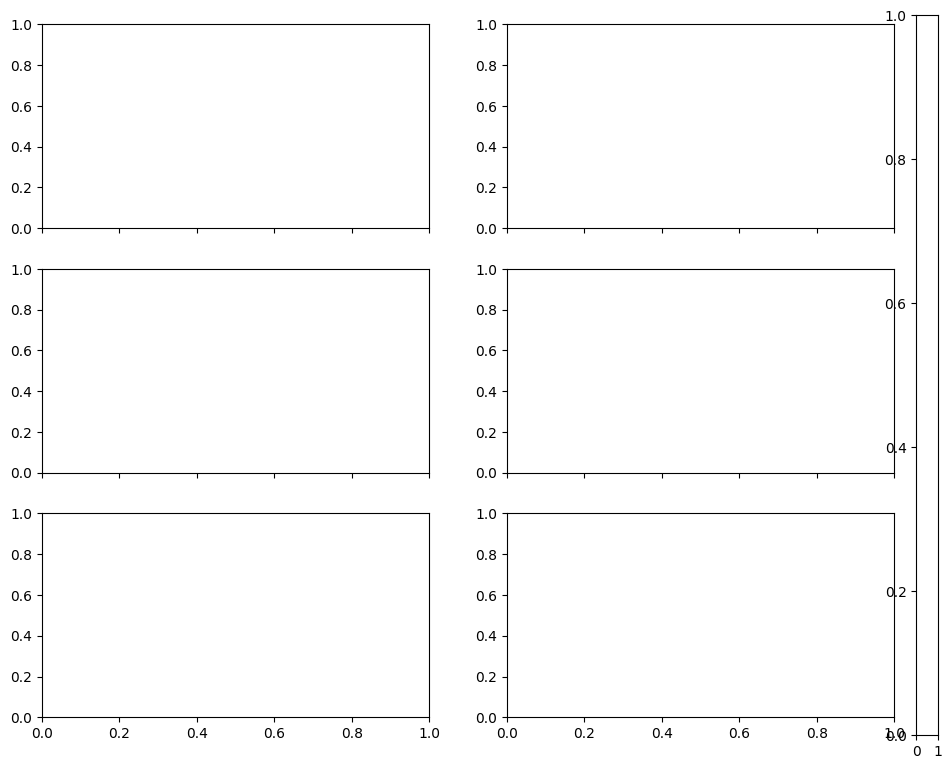

In [1]:
# 3×2 figure:
# col 0: absolute beyond-EdS multipoles (colored by μ0) + GR in black WITH ERROR BARS
# col 1: significance = (bEdS − EdS) / σ_GR per multipole (colored by μ0) + GR (zero line) in black

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy

# ---- pyfkpt (new fkpt wrapper) ----
import pyfkpt.rsd as pyfkpt

# ---- ISiTGR ----
import isitgr
from isitgr import model
def zpad_guard_for_single_z(z0, *, dln_a=5e-3, window=9, guard_extra=2, a_floor=1e-4):
    """
    Redshift pad that guarantees a *central* ln a window around z0.
    guard_extra adds a couple of half-steps beyond the nominal window.
    """
    import numpy as np
    w    = int(window) + (window % 2 == 0)
    half = w // 2
    a0   = 1.0/(1.0 + float(z0))
    lna0 = np.log(a0)
    # central window nodes
    offs = np.arange(-half, half+1, dtype=float) * float(dln_a)
    lnai = lna0 + offs
    # add a small guard on both sides so central window really fits
    guard = (half + int(guard_extra)) * float(dln_a)
    lnai  = np.concatenate([lnai, [lna0 - guard, lna0 + guard]])
    ai    = np.clip(np.exp(np.unique(np.sort(lnai))), a_floor, 1.0)
    return np.unique(np.sort(1.0/ai - 1.0))

# ---- thecov (Gaussian covariances of P_ell) ----
from thecov import geometry, covariance

# ==========================
# Configuration
# ==========================
h      = 0.6711
ombh2  = 0.022
omch2  = 0.122
omnuh2 = 0.0
As     = 2e-9
ns     = 0.965
z_pk   = 0.3

Om     = (ombh2 + omch2 + omnuh2) / (h**2)
print("Omega_m:", Om)

KMAX = 0.3
CAMB_KMAX = max(2.0, 16.0 * KMAX) * 1.25

# nuisance / bias
b1 = 1.70
b2 = -0.45
bs2  = -4/7*(b1 - 1)
b3nl = 32/315*(b1 - 1)
alpha0, alpha2, alpha4, ctilde = 3.0, -29.0, 0.0, 0.0
alpha0shot, alpha2shot, pshotp = 0.08, -8.0, 5000.0
nuis = [b1,b2,bs2,b3nl,alpha0,alpha2,alpha4,ctilde,alpha0shot,alpha2shot,pshotp]

# μ0 sweep (include GR=0)
mu0_vals = np.linspace(0.0, 0.5, 15)

# BGS tracer settings for covariance
BGS_nbar   = 5.0e-4          # (h/Mpc)^3
BGS_volume = 2000.0**3       # (Mpc/h)^3   (i.e., (2 Gpc/h)^3 box)

# k-range to display / use for σ
KMIN_MASK = 0.01
KMAX_MASK = 0.20

base_common = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    nquadSteps=300, chatty=0,
    model="HDKI",
    mg_variant="mu_OmDE",
)

# ==========================
# Helper: return EdS & bEdS multipoles for given μ0
# ==========================
def compute_multipoles_pair(mu0):
    # ---- ISiTGR params ----
    pars = isitgr.CAMBparams()
    pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, mnu=93.14*omnuh2,
                       MG_parameterization="muSigma", mu0=mu0)
    pars.InitPower.set_params(As=As, ns=ns)

    # precision knobs for f(z,k) (good defaults)
    dln_a   = 5e-3
    window  = 9            # odd
    polyord = 2            # 1–3 reasonable; 2 is robust

    # build a *local guarded* pad around z_pk so the central window always fits
    z_pad = zpad_guard_for_single_z(z_pk, dln_a=dln_a, window=window, guard_extra=2, a_floor=1e-4)

    # run once on the pad
    pars.set_matter_power(redshifts=z_pad, kmax=CAMB_KMAX)
    pars.NonLinear = model.NonLinear_none
    results = isitgr.get_results(pars)

    # linear P(k) and f(k) at zeff=z_pk
    PK, _, ks = results.get_matter_power_interpolator(
        nonlinear=False, hubble_units=True, k_hunit=True, return_z_k=True, silent=True
    )
    pk_lin = PK.P(z_pk, ks)

    ks_fk, fzk = results.f_of_ak_from_dP_da(
        [z_pk],
        dln_a=dln_a, window=window, polyorder=polyord,
        hubble_units=True, k_hunit=True, require_central=True,  # central is guaranteed by guard
        smooth_median_width=0
    )
    fk_lin = fzk[0]                    # (Nk,)
    assert np.allclose(ks_fk, ks)      # same k-grid

    # cut to analysis k-range
    mask   = ks <= KMAX
    ks_cut = ks[mask]
    pk_cut = pk_lin[mask]
    fk_cut = fk_lin[mask]

    # small-k average for f0 (for tables that want a single number)
    smallk = ks_cut < 3e-3
    f0 = float(np.mean(fk_cut[smallk])) if np.any(smallk) else float(fk_cut[0])

    # FKPT evaluation grid
    base = dict(
        **base_common,
        mu0=mu0,
        kmin=float(max(1e-3, ks_cut.min())),
        kmax=float(min(ks_cut.max(), KMAX)),
        Nk=int(min(ks_cut.size, 50)),
    )
    k_eval = np.linspace(base["kmin"], base["kmax"], base["Nk"])

    # EdS kernels
    pE = deepcopy(base); pE["rescale_PS"]=False; pE["use_beyond_eds_kernels"]=False
    tE = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **pE)
    kE, P0E, P2E, P4E = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tE)

    # beyond-EdS kernels
    pB = deepcopy(base); pB["rescale_PS"]=False; pB["use_beyond_eds_kernels"]=True
    tB = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **pB)
    kB, P0B, P2B, P4B = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tB)

    assert np.allclose(kE, kB)
    return kB, (P0E, P2E, P4E), (P0B, P2B, P4B)

def interp_to_grid(k_src, y_src, k_target):
    # assumes k_src is increasing; if not, sort first
    return np.interp(k_target, k_src, y_src)

# ================= plot: 3×2 grid =================
plt.close('all')
fig, axes = plt.subplots(3, 2, figsize=(11, 9), sharex='col')
(ax0_abs, ax0_sig), (ax2_abs, ax2_sig), (ax4_abs, ax4_sig) = axes

# --- color map for μ0 sweep ---
cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=mu0_vals.min(), vmax=mu0_vals.max())
fig.subplots_adjust(right=0.90)
cax = fig.add_axes([0.92, 0.09, 0.02, 0.80])
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])

k_for_cov = None
P0E_GR = P2E_GR = P4E_GR = None
P0B_GR = P2B_GR = P4B_GR = None

# ---------- sweep over μ0 (first pass to cache GR & draw absolute curves) ----------
for mu0 in mu0_vals:
    k, (P0E, P2E, P4E), (P0B, P2B, P4B) = compute_multipoles_pair(mu0)
    color = cmap(norm(mu0))

    if mu0 == 0.0:
        k_for_cov = k.copy()
        P0E_GR, P2E_GR, P4E_GR = P0E.copy(), P2E.copy(), P4E.copy()
        P0B_GR, P2B_GR, P4B_GR = P0B.copy(), P2B.copy(), P4B.copy()

    # left column: absolute beyond-EdS k*Pℓ (colored by μ0)
    ax0_abs.plot(k, k*P0B, color=color, lw=1.2)
    ax2_abs.plot(k, k*P2B, color=color, lw=1.2)
    ax4_abs.plot(k, k*P4B, color=color, lw=1.2)

if k_for_cov is None:
    raise RuntimeError("No GR (mu0=0) case computed; can't build covariance.")

# ---------- build covariance from GR (BGS tracer) ----------
# Construct uniform edges from centers
Nk_full = k_for_cov.size
dk_full = (k_for_cov[-1] - k_for_cov[0]) / (Nk_full - 1)
kmin_edge_full = k_for_cov[0] - dk_full/2.0
kmax_edge_full = k_for_cov[-1] + dk_full/2.0

geom = geometry.BoxGeometry(volume=BGS_volume, nbar=BGS_nbar)
cov  = covariance.GaussianCovariance(geom)
cov.set_kbins(kmin=kmin_edge_full, kmax=kmax_edge_full, dk=dk_full)

# supply GR multipoles; mark monopole as including shot noise (since rsd_multipoles used shot-noise nuisances)
cov.set_galaxy_pk_multipole(P0B_GR, ell=0, has_shotnoise=True)
cov.set_galaxy_pk_multipole(P2B_GR, ell=2)
cov.set_galaxy_pk_multipole(P4B_GR, ell=4)
cov.compute_covariance()

# extract diagonal errors per multipole from the stacked covariance:
diag_full = np.sqrt(np.diag(cov.cov))
sig0_full = diag_full[0:Nk_full]
sig2_full = diag_full[Nk_full:2*Nk_full]
sig4_full = diag_full[2*Nk_full:3*Nk_full]

# ---------- apply k mask consistently ----------
mask_cov = (k_for_cov > KMIN_MASK) & (k_for_cov < KMAX_MASK)

k_for_cov = k_for_cov[mask_cov]
P0B_GR = P0B_GR[mask_cov]; P2B_GR = P2B_GR[mask_cov]; P4B_GR = P4B_GR[mask_cov]
P0E_GR = P0E_GR[mask_cov]; P2E_GR = P2E_GR[mask_cov]; P4E_GR = P4E_GR[mask_cov]
sig0_GR = sig0_full[mask_cov]; sig2_GR = sig2_full[mask_cov]; sig4_GR = sig4_full[mask_cov]

# ---------- overplot GR (black) with error bars on abs column ----------
ax0_abs.errorbar(k_for_cov, k_for_cov*P0B_GR, yerr=k_for_cov*sig0_GR, fmt='-', color='k', lw=1.8, capsize=0)
ax2_abs.errorbar(k_for_cov, k_for_cov*P2B_GR, yerr=k_for_cov*sig2_GR, fmt='-', color='k', lw=1.8, capsize=0)
ax4_abs.errorbar(k_for_cov, k_for_cov*P4B_GR, yerr=k_for_cov*sig4_GR, fmt='-', color='k', lw=1.8, capsize=0)

# ---------- recompute sweep to plot significance in right column (interpolate to masked cov grid) ----------
for mu0 in mu0_vals:
    k, (P0E, P2E, P4E), (P0B, P2B, P4B) = compute_multipoles_pair(mu0)
    color = cmap(norm(mu0))

    d0 = P0B - P0E
    d2 = P2B - P2E
    d4 = P4B - P4E

    d0_on_cov = interp_to_grid(k, d0, k_for_cov)
    d2_on_cov = interp_to_grid(k, d2, k_for_cov)
    d4_on_cov = interp_to_grid(k, d4, k_for_cov)

    s0 = d0_on_cov / sig0_GR
    s2 = d2_on_cov / sig2_GR
    s4 = d4_on_cov / sig4_GR

    ax0_sig.plot(k_for_cov, s0, color=color, lw=1.2)
    ax2_sig.plot(k_for_cov, s2, color=color, lw=1.2)
    ax4_sig.plot(k_for_cov, s4, color=color, lw=1.2)

# GR reference line (zero significance) in black
ax0_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)
ax2_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)
ax4_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)

# ----- styling -----
# col 0: absolute (with GR + error bars); note y is k * P_ell
for ax, lab in zip([ax0_abs, ax2_abs, ax4_abs],
                   [r"$k\,P_0(k)$", r"$k\,P_2(k)$", r"$k\,P_4(k)$"]):
    ax.grid(True, alpha=0.25)
    ax.set_ylabel(lab)

# col 1: significance (bEdS − EdS)/σ_GR
for ax, lab in zip([ax0_sig, ax2_sig, ax4_sig],
                   [r"$(P_0^{\rm bEdS}-P_0^{\rm EdS})/\sigma_0^{\rm GR}$",
                    r"$(P_2^{\rm bEdS}-P_2^{\rm EdS})/\sigma_2^{\rm GR}$",
                    r"$(P_4^{\rm bEdS}-P_4^{\rm EdS})/\sigma_4^{\rm GR}$"]):
    ax.axhline(0, color='k', lw=1.0, alpha=0.5)
    ax.grid(True, alpha=0.15)
    ax.set_ylabel(lab)

# x limits & labels
for col in range(2):
    for ax in axes[:, col]:
        ax.set_xlim(k_for_cov[0], k_for_cov[-1])
for ax in axes[-1, :]:
    ax.set_xlabel(r"$k\,[h\,\mathrm{Mpc}^{-1}]$")

# titles
axes[0,0].set_title("Absolute bEdS (colored by $\\mu_0$) + GR with errors (BGS)", fontsize=12)
axes[0,1].set_title("(bEdS − EdS) / $\\sigma^{\\rm GR}$ (BGS)", fontsize=12)

# colorbar
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r'$\mu_0$')

fig.suptitle(fr"Multipoles at $z={z_pk}$; $\Omega_m={Om:.3f}$  — BGS covariance (Gaussian, box)", y=0.98)
plt.tight_layout(rect=[0, 0, 0.90, 0.96])
plt.show()

Omega_m: 0.31973340628583885
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts h

/tmp/ipykernel_3675132/3396624770.py:305: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 0.96])


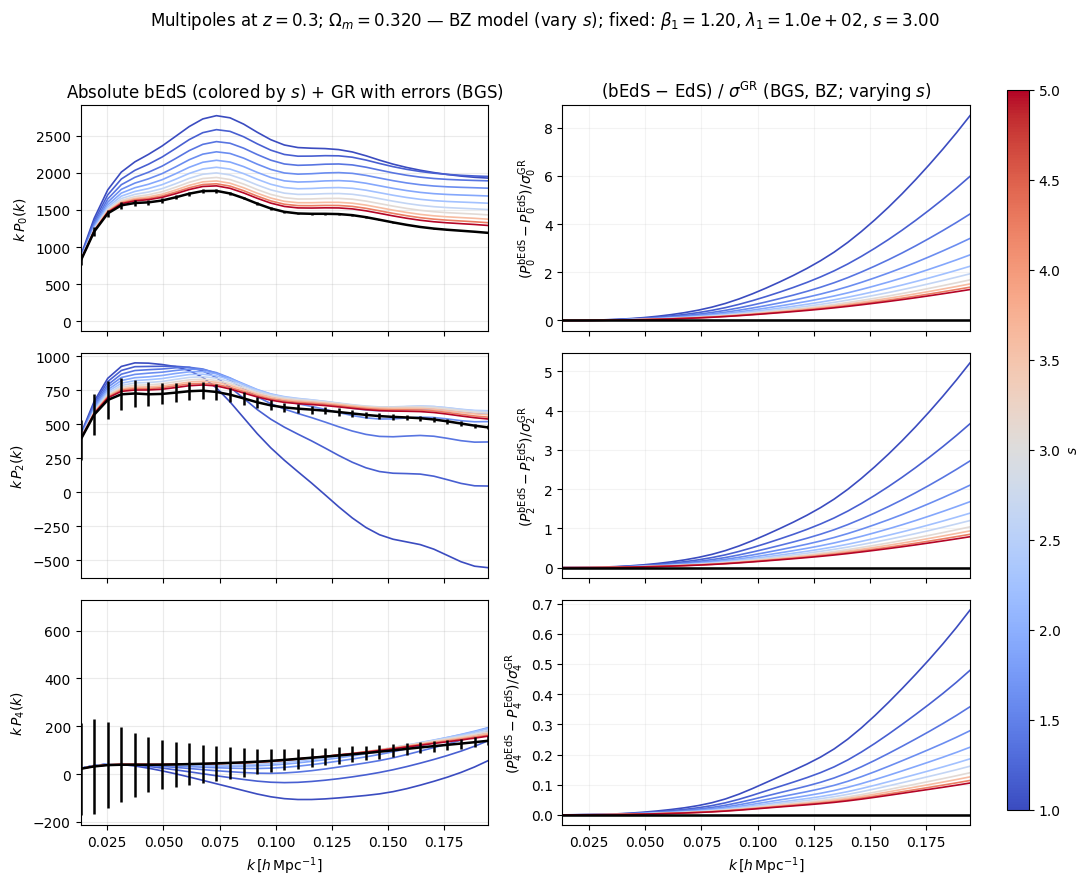

In [4]:
# 3×2 figure:
# col 0: absolute beyond-EdS multipoles (colored by chosen param) + GR in black WITH ERROR BARS
# col 1: significance = (bEdS − EdS) / σ_GR per multipole (colored by chosen param) + GR (zero line) in black

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm   # <-- for log color scale when sweeping s
from copy import deepcopy

# ---- pyfkpt (new fkpt wrapper) ----
import pyfkpt.rsd as pyfkpt

# ---- ISiTGR ----
import isitgr
from isitgr import model

# ---- thecov (Gaussian covariances of P_ell) ----
from thecov import geometry, covariance

# ==========================
# Configuration
# ==========================
h      = 0.6711
ombh2  = 0.022
omch2  = 0.122
omnuh2 = 0.0
As     = 2e-9
ns     = 0.965
z_pk   = 0.3

Om     = (ombh2 + omch2 + omnuh2) / (h**2)
print("Omega_m:", Om)

KMAX = 0.3
CAMB_KMAX = max(2.0, 16.0 * KMAX) * 1.25

# nuisance / bias
b1 = 1.70
b2 = -0.45
bs2  = -4/7*(b1 - 1)
b3nl = 32/315*(b1 - 1)
alpha0, alpha2, alpha4, ctilde = 3.0, -29.0, 0.0, 0.0
alpha0shot, alpha2shot, pshotp = 0.08, -8.0, 5000.0
nuis = [b1,b2,bs2,b3nl,alpha0,alpha2,alpha4,ctilde,alpha0shot,alpha2shot,pshotp]

# ==========================
# Choose which BZ parameter to sweep: 'beta1' | 'lambda1' | 's'
# ==========================
SWEEP_PARAM = 's'  # <-- change as needed

# fixed/reference values when sweeping the others
fixed_beta1   = 1.2
fixed_lambda1 = 1e2
fixed_s       = 3.0

# Default linear/geometric ranges for beta1/lambda1; s handled specially below
default_ranges = {
    'beta1':   np.linspace(0.5, 1.5, 11),
    's': np.geomspace(1, 5, 11),
}

# Pretty symbols & formatters
def param_meta(name):
    if name == 'beta1':
        return r'\beta_1', r'$\beta_1$', lambda v: f"{v:.2f}"
    if name == 'lambda1':
        return r'\lambda_1', r'$\lambda_1$', lambda v: f"{v:.1e}"
    if name == 's':
        return r's', r'$s$', lambda v: f"{v:.2f}"
    raise ValueError("SWEEP_PARAM must be one of {'beta1','lambda1','s'}")

param_tex, param_tex_math, fmt = param_meta(SWEEP_PARAM)

# ---- Build sweep values and colormap normalizer ----
cmap = plt.get_cmap('coolwarm')

if SWEEP_PARAM == 'lambda_1':
    # Your requested log-sweep with explicit zero:
    n_values = 10  # -> 9 positive log points + 1 zero = 10 total
    log_vals   = np.logspace(1, 6, n_values - 1)  # 10^1 .. 10^6 (9 pts)
    x_vals     = np.insert(log_vals, 0, 0.0)
    positives  = x_vals[x_vals > 0]
    norm       = LogNorm(vmin=positives.min(), vmax=positives.max())
else:
    x_vals = default_ranges[SWEEP_PARAM]
    norm   = mpl.colors.Normalize(vmin=x_vals.min(), vmax=x_vals.max())

# ---- BGS tracer settings for covariance ----
BGS_nbar   = 5.0e-4
BGS_volume = 2000.0**3

# k-range to display / use for σ
KMIN_MASK = 0.01
KMAX_MASK = 0.20

base_common = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    nquadSteps=300, chatty=0,
    model="HDKI",
    mg_variant="BZ",
)

# ==========================
# Helper: return EdS & bEdS multipoles for given BZ params
# ==========================
def compute_multipoles_pair(beta_1, lambda_1, exp_s):
    pars = isitgr.CAMBparams()
    pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, mnu=93.14*omnuh2,
                       MG_parameterization="mueta", use_BZ_form=True,
                       beta_1=beta_1, lambda_1=lambda_1, exp_s=exp_s)
    pars.InitPower.set_params(As=As, ns=ns)

    # tightly sample around z_pk for f(k,z)
    dln_a = 1e-3
    a0 = 1.0/(1.0 + z_pk)
    z1 = 1.0/(a0*np.exp(-dln_a)) - 1.0
    z2 = 1.0/(a0*np.exp(+dln_a)) - 1.0
    z_list = sorted([z1, z_pk, z2, 0.0])

    pars.set_matter_power(redshifts=z_list, kmax=CAMB_KMAX)
    pars.NonLinear = model.NonLinear_none
    results = isitgr.get_results(pars)

    PK, _, ks = results.get_matter_power_interpolator(
        nonlinear=False, hubble_units=True, k_hunit=True, return_z_k=True, silent=True
    )
    pk_lin = PK.P(z_pk, ks)
    kh_fk, fk_lin = results.f_of_k(z_pk, hubble_units=True, k_hunit=True)
    assert np.allclose(kh_fk, ks)

    mask   = ks <= KMAX
    ks_cut = ks[mask]
    pk_cut = pk_lin[mask]
    fk_cut = fk_lin[mask]

    smallk = ks_cut < 3e-3
    f0 = float(np.mean(fk_cut[smallk])) if np.any(smallk) else float(fk_cut[0])

    base = dict(
        **base_common,
        beta_1=beta_1,
        lambda_1=lambda_1,
        exp_s=exp_s,
        kmin=float(max(1e-3, ks_cut.min())),
        kmax=float(min(ks_cut.max(), KMAX)),
        Nk=int(min(ks_cut.size, 50)),
    )
    k_eval = np.linspace(base["kmin"], base["kmax"], base["Nk"])

    # EdS kernels
    pE = deepcopy(base); pE["rescale_PS"]=False; pE["use_beyond_eds_kernels"]=False
    tE = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **pE)
    kE, P0E, P2E, P4E = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tE)

    # beyond-EdS kernels
    pB = deepcopy(base); pB["rescale_PS"]=False; pB["use_beyond_eds_kernels"]=True
    tB = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **pB)
    kB, P0B, P2B, P4B = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tB)

    assert np.allclose(kE, kB)
    return kB, (P0E, P2E, P4E), (P0B, P2B, P4B)

def interp_to_grid(k_src, y_src, k_target):
    return np.interp(k_target, k_src, y_src)

def kwargs_for_value(param_name, x):
    if param_name == 'beta1':
        return dict(beta_1=x,           lambda_1=fixed_lambda1, exp_s=fixed_s)
    if param_name == 'lambda1':
        return dict(beta_1=fixed_beta1, lambda_1=x,             exp_s=fixed_s)
    if param_name == 's':
        return dict(beta_1=fixed_beta1, lambda_1=fixed_lambda1, exp_s=x)
    raise ValueError

# ================= plot: 3×2 grid =================
plt.close('all')
fig, axes = plt.subplots(3, 2, figsize=(11, 9), sharex='col')
(ax0_abs, ax0_sig), (ax2_abs, ax2_sig), (ax4_abs, ax4_sig) = axes

# colorbar axis
fig.subplots_adjust(right=0.90)
cax = fig.add_axes([0.92, 0.09, 0.02, 0.80])

# ScalarMappable for colorbar with the chosen norm
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k_for_cov = None
P0E_GR = P2E_GR = P4E_GR = None
P0B_GR = P2B_GR = P4B_GR = None

# ---------- GR baseline FIRST (β1=1.0; λ1=0; s=0) ----------
k_for_cov, (P0E_GR, P2E_GR, P4E_GR), (P0B_GR, P2B_GR, P4B_GR) = compute_multipoles_pair(
    beta_1=1.0, lambda_1=0.0, exp_s=0.0
)

# ---------- sweep (absolute curves, left column) ----------
for x_val in x_vals:
    k, (P0E, P2E, P4E), (P0B, P2B, P4B) = compute_multipoles_pair(**kwargs_for_value(SWEEP_PARAM, x_val))
    if SWEEP_PARAM == 'lambda_1' and x_val == 0.0:
        color = 'gray'  # LogNorm is undefined at 0 — use a neutral color
    else:
        color = cmap(norm(x_val))
    ax0_abs.plot(k, k*P0B, color=color, lw=1.2)
    ax2_abs.plot(k, k*P2B, color=color, lw=1.2)
    ax4_abs.plot(k, k*P4B, color=color, lw=1.2)

# ---------- build covariance from GR (BGS tracer) ----------
Nk_full = k_for_cov.size
dk_full = (k_for_cov[-1] - k_for_cov[0]) / (Nk_full - 1)
kmin_edge_full = k_for_cov[0] - dk_full/2.0
kmax_edge_full = k_for_cov[-1] + dk_full/2.0

geom = geometry.BoxGeometry(volume=BGS_volume, nbar=BGS_nbar)
cov  = covariance.GaussianCovariance(geom)
cov.set_kbins(kmin=kmin_edge_full, kmax=kmax_edge_full, dk=dk_full)

cov.set_galaxy_pk_multipole(P0B_GR, ell=0, has_shotnoise=True)
cov.set_galaxy_pk_multipole(P2B_GR, ell=2)
cov.set_galaxy_pk_multipole(P4B_GR, ell=4)
cov.compute_covariance()

diag_full = np.sqrt(np.diag(cov.cov))
sig0_full = diag_full[0:Nk_full]
sig2_full = diag_full[Nk_full:2*Nk_full]
sig4_full = diag_full[2*Nk_full:3*Nk_full]

# ---------- apply k mask consistently ----------
mask_cov = (k_for_cov > KMIN_MASK) & (k_for_cov < KMAX_MASK)

k_for_cov = k_for_cov[mask_cov]
P0B_GR = P0B_GR[mask_cov]; P2B_GR = P2B_GR[mask_cov]; P4B_GR = P4B_GR[mask_cov]
P0E_GR = P0E_GR[mask_cov]; P2E_GR = P2E_GR[mask_cov]; P4E_GR = P4E_GR[mask_cov]
sig0_GR = sig0_full[mask_cov]; sig2_GR = sig2_full[mask_cov]; sig4_GR = sig4_full[mask_cov]

# ---------- GR with error bars (absolute column) ----------
ax0_abs.errorbar(k_for_cov, k_for_cov*P0B_GR, yerr=k_for_cov*sig0_GR, fmt='-', color='k', lw=1.8, capsize=0)
ax2_abs.errorbar(k_for_cov, k_for_cov*P2B_GR, yerr=k_for_cov*sig2_GR, fmt='-', color='k', lw=1.8, capsize=0)
ax4_abs.errorbar(k_for_cov, k_for_cov*P4B_GR, yerr=k_for_cov*sig4_GR, fmt='-', color='k', lw=1.8, capsize=0)

# ---------- significance (right column): (bEdS − EdS)/σ_GR ----------
for x_val in x_vals:
    k, (P0E, P2E, P4E), (P0B, P2B, P4B) = compute_multipoles_pair(**kwargs_for_value(SWEEP_PARAM, x_val))
    if SWEEP_PARAM == 's' and x_val == 0.0:
        color = 'gray'
    else:
        color = cmap(norm(x_val))

    d0 = P0B - P0E
    d2 = P2B - P2E
    d4 = P4B - P4E

    d0_on_cov = interp_to_grid(k, d0, k_for_cov)
    d2_on_cov = interp_to_grid(k, d2, k_for_cov)
    d4_on_cov = interp_to_grid(k, d4, k_for_cov)

    s0 = d0_on_cov / sig0_GR
    s2 = d2_on_cov / sig2_GR
    s4 = d4_on_cov / sig4_GR

    ax0_sig.plot(k_for_cov, s0, color=color, lw=1.2)
    ax2_sig.plot(k_for_cov, s2, color=color, lw=1.2)
    ax4_sig.plot(k_for_cov, s4, color=color, lw=1.2)

# GR reference zero line
ax0_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)
ax2_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)
ax4_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)

# ----- styling -----
for ax, lab in zip([ax0_abs, ax2_abs, ax4_abs],
                   [r"$k\,P_0(k)$", r"$k\,P_2(k)$", r"$k\,P_4(k)$"]):
    ax.grid(True, alpha=0.25)
    ax.set_ylabel(lab)

for ax, lab in zip([ax0_sig, ax2_sig, ax4_sig],
                   [r"$(P_0^{\rm bEdS}-P_0^{\rm EdS})/\sigma_0^{\rm GR}$",
                    r"$(P_2^{\rm bEdS}-P_2^{\rm EdS})/\sigma_2^{\rm GR}$",
                    r"$(P_4^{\rm bEdS}-P_4^{\rm EdS})/\sigma_4^{\rm GR}$"]):
    ax.axhline(0, color='k', lw=1.0, alpha=0.5)
    ax.grid(True, alpha=0.15)
    ax.set_ylabel(lab)

for col in range(2):
    for ax in axes[:, col]:
        ax.set_xlim(k_for_cov[0], k_for_cov[-1])
for ax in axes[-1, :]:
    ax.set_xlabel(r"$k\,[h\,\mathrm{Mpc}^{-1}]$")

# Titles & colorbar
axes[0,0].set_title(fr"Absolute bEdS (colored by {param_tex_math}) + GR with errors (BGS)", fontsize=12)
axes[0,1].set_title(fr"(bEdS − EdS) / $\sigma^{{\rm GR}}$ (BGS, BZ; varying {param_tex_math})", fontsize=12)

cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(param_tex_math)

fixed_desc = fr"$\beta_1={fixed_beta1:.2f}$, $\lambda_1={fixed_lambda1:.1e}$, $s={fixed_s:.2f}$"
fig.suptitle(fr"Multipoles at $z={z_pk}$; $\Omega_m={Om:.3f}$ — BZ model (vary {param_tex_math}); fixed: {fixed_desc}",
             y=0.98)

plt.tight_layout(rect=[0, 0, 0.90, 0.96])
plt.show()


Omega_m: 0.31973340628583885
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts h

/tmp/ipykernel_3675132/3279755106.py:305: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 0.96])


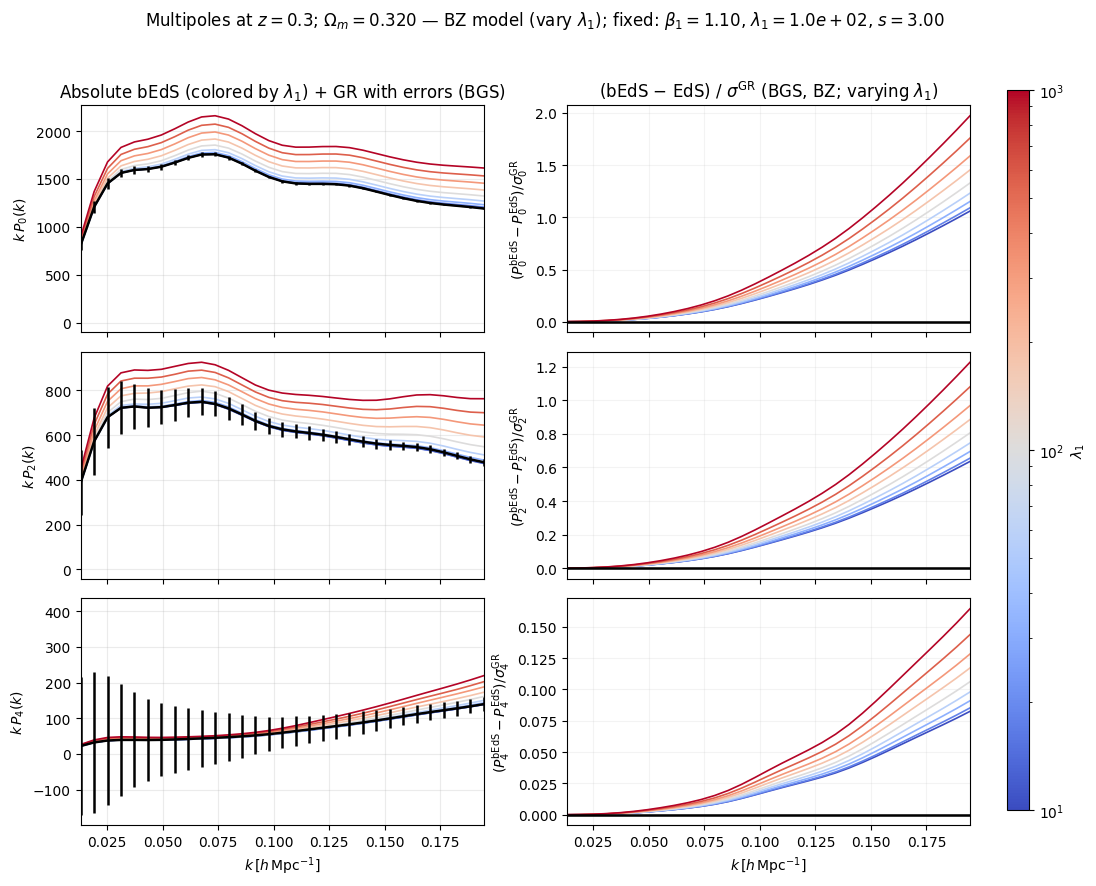

In [8]:
# 3×2 figure:
# col 0: absolute beyond-EdS multipoles (colored by chosen param) + GR in black WITH ERROR BARS
# col 1: significance = (bEdS − EdS) / σ_GR per multipole (colored by chosen param) + GR (zero line) in black

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm   # <-- for log color scale when sweeping s
from copy import deepcopy

# ---- pyfkpt (new fkpt wrapper) ----
import pyfkpt.rsd as pyfkpt

# ---- ISiTGR ----
import isitgr
from isitgr import model

# ---- thecov (Gaussian covariances of P_ell) ----
from thecov import geometry, covariance

# ==========================
# Configuration
# ==========================
h      = 0.6711
ombh2  = 0.022
omch2  = 0.122
omnuh2 = 0.0
As     = 2e-9
ns     = 0.965
z_pk   = 0.3

Om     = (ombh2 + omch2 + omnuh2) / (h**2)
print("Omega_m:", Om)

KMAX = 0.3
CAMB_KMAX = max(2.0, 16.0 * KMAX) * 1.25

# nuisance / bias
b1 = 1.70
b2 = -0.45
bs2  = -4/7*(b1 - 1)
b3nl = 32/315*(b1 - 1)
alpha0, alpha2, alpha4, ctilde = 3.0, -29.0, 0.0, 0.0
alpha0shot, alpha2shot, pshotp = 0.08, -8.0, 5000.0
nuis = [b1,b2,bs2,b3nl,alpha0,alpha2,alpha4,ctilde,alpha0shot,alpha2shot,pshotp]

# ==========================
# Choose which BZ parameter to sweep: 'beta1' | 'lambda1' | 's'
# ==========================
SWEEP_PARAM = 'lambda1'  # <-- change as needed

# fixed/reference values when sweeping the others
fixed_beta1   = 1.1
fixed_lambda1 = 1e2
fixed_s       = 3.0

# Default linear/geometric ranges for beta1/lambda1; s handled specially below
default_ranges = {
    'beta1':   np.linspace(0.5, 1.5, 11),
    's': np.geomspace(1, 5, 11),
}

# Pretty symbols & formatters
def param_meta(name):
    if name == 'beta1':
        return r'\beta_1', r'$\beta_1$', lambda v: f"{v:.2f}"
    if name == 'lambda1':
        return r'\lambda_1', r'$\lambda_1$', lambda v: f"{v:.1e}"
    if name == 's':
        return r's', r'$s$', lambda v: f"{v:.2f}"
    raise ValueError("SWEEP_PARAM must be one of {'beta1','lambda1','s'}")

param_tex, param_tex_math, fmt = param_meta(SWEEP_PARAM)

# ---- Build sweep values and colormap normalizer ----
cmap = plt.get_cmap('coolwarm')

if SWEEP_PARAM == 'lambda1':
    # Your requested log-sweep with explicit zero:
    n_values = 10  # -> 9 positive log points + 1 zero = 10 total
    log_vals   = np.logspace(1, 3, n_values - 1)  # 10^1 .. 10^6 (9 pts)
    x_vals     = np.insert(log_vals, 0, 0.0)
    positives  = x_vals[x_vals > 0]
    norm       = LogNorm(vmin=positives.min(), vmax=positives.max())
else:
    x_vals = default_ranges[SWEEP_PARAM]
    norm   = mpl.colors.Normalize(vmin=x_vals.min(), vmax=x_vals.max())

# ---- BGS tracer settings for covariance ----
BGS_nbar   = 5.0e-4
BGS_volume = 2000.0**3

# k-range to display / use for σ
KMIN_MASK = 0.01
KMAX_MASK = 0.20

base_common = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    nquadSteps=300, chatty=0,
    model="HDKI",
    mg_variant="BZ",
)

# ==========================
# Helper: return EdS & bEdS multipoles for given BZ params
# ==========================
def compute_multipoles_pair(beta_1, lambda_1, exp_s):
    pars = isitgr.CAMBparams()
    pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, mnu=93.14*omnuh2,
                       MG_parameterization="mueta", use_BZ_form=True,
                       beta_1=beta_1, lambda_1=lambda_1, exp_s=exp_s)
    pars.InitPower.set_params(As=As, ns=ns)

    # tightly sample around z_pk for f(k,z)
    dln_a = 1e-3
    a0 = 1.0/(1.0 + z_pk)
    z1 = 1.0/(a0*np.exp(-dln_a)) - 1.0
    z2 = 1.0/(a0*np.exp(+dln_a)) - 1.0
    z_list = sorted([z1, z_pk, z2, 0.0])

    pars.set_matter_power(redshifts=z_list, kmax=CAMB_KMAX)
    pars.NonLinear = model.NonLinear_none
    results = isitgr.get_results(pars)

    PK, _, ks = results.get_matter_power_interpolator(
        nonlinear=False, hubble_units=True, k_hunit=True, return_z_k=True, silent=True
    )
    pk_lin = PK.P(z_pk, ks)
    kh_fk, fk_lin = results.f_of_k(z_pk, hubble_units=True, k_hunit=True)
    assert np.allclose(kh_fk, ks)

    mask   = ks <= KMAX
    ks_cut = ks[mask]
    pk_cut = pk_lin[mask]
    fk_cut = fk_lin[mask]

    smallk = ks_cut < 3e-3
    f0 = float(np.mean(fk_cut[smallk])) if np.any(smallk) else float(fk_cut[0])

    base = dict(
        **base_common,
        beta_1=beta_1,
        lambda_1=lambda_1,
        exp_s=exp_s,
        kmin=float(max(1e-3, ks_cut.min())),
        kmax=float(min(ks_cut.max(), KMAX)),
        Nk=int(min(ks_cut.size, 50)),
    )
    k_eval = np.linspace(base["kmin"], base["kmax"], base["Nk"])

    # EdS kernels
    pE = deepcopy(base); pE["rescale_PS"]=False; pE["use_beyond_eds_kernels"]=False
    tE = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **pE)
    kE, P0E, P2E, P4E = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tE)

    # beyond-EdS kernels
    pB = deepcopy(base); pB["rescale_PS"]=False; pB["use_beyond_eds_kernels"]=True
    tB = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **pB)
    kB, P0B, P2B, P4B = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tB)

    assert np.allclose(kE, kB)
    return kB, (P0E, P2E, P4E), (P0B, P2B, P4B)

def interp_to_grid(k_src, y_src, k_target):
    return np.interp(k_target, k_src, y_src)

def kwargs_for_value(param_name, x):
    if param_name == 'beta1':
        return dict(beta_1=x,           lambda_1=fixed_lambda1, exp_s=fixed_s)
    if param_name == 'lambda1':
        return dict(beta_1=fixed_beta1, lambda_1=x,             exp_s=fixed_s)
    if param_name == 's':
        return dict(beta_1=fixed_beta1, lambda_1=fixed_lambda1, exp_s=x)
    raise ValueError

# ================= plot: 3×2 grid =================
plt.close('all')
fig, axes = plt.subplots(3, 2, figsize=(11, 9), sharex='col')
(ax0_abs, ax0_sig), (ax2_abs, ax2_sig), (ax4_abs, ax4_sig) = axes

# colorbar axis
fig.subplots_adjust(right=0.90)
cax = fig.add_axes([0.92, 0.09, 0.02, 0.80])

# ScalarMappable for colorbar with the chosen norm
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k_for_cov = None
P0E_GR = P2E_GR = P4E_GR = None
P0B_GR = P2B_GR = P4B_GR = None

# ---------- GR baseline FIRST (β1=1.0; λ1=0; s=0) ----------
k_for_cov, (P0E_GR, P2E_GR, P4E_GR), (P0B_GR, P2B_GR, P4B_GR) = compute_multipoles_pair(
    beta_1=1.0, lambda_1=0.0, exp_s=0.0
)

# ---------- sweep (absolute curves, left column) ----------
for x_val in x_vals:
    k, (P0E, P2E, P4E), (P0B, P2B, P4B) = compute_multipoles_pair(**kwargs_for_value(SWEEP_PARAM, x_val))
    if SWEEP_PARAM == 'lambda1' and x_val == 0.0:
        color = 'gray'  # LogNorm is undefined at 0 — use a neutral color
    else:
        color = cmap(norm(x_val))
    ax0_abs.plot(k, k*P0B, color=color, lw=1.2)
    ax2_abs.plot(k, k*P2B, color=color, lw=1.2)
    ax4_abs.plot(k, k*P4B, color=color, lw=1.2)

# ---------- build covariance from GR (BGS tracer) ----------
Nk_full = k_for_cov.size
dk_full = (k_for_cov[-1] - k_for_cov[0]) / (Nk_full - 1)
kmin_edge_full = k_for_cov[0] - dk_full/2.0
kmax_edge_full = k_for_cov[-1] + dk_full/2.0

geom = geometry.BoxGeometry(volume=BGS_volume, nbar=BGS_nbar)
cov  = covariance.GaussianCovariance(geom)
cov.set_kbins(kmin=kmin_edge_full, kmax=kmax_edge_full, dk=dk_full)

cov.set_galaxy_pk_multipole(P0B_GR, ell=0, has_shotnoise=True)
cov.set_galaxy_pk_multipole(P2B_GR, ell=2)
cov.set_galaxy_pk_multipole(P4B_GR, ell=4)
cov.compute_covariance()

diag_full = np.sqrt(np.diag(cov.cov))
sig0_full = diag_full[0:Nk_full]
sig2_full = diag_full[Nk_full:2*Nk_full]
sig4_full = diag_full[2*Nk_full:3*Nk_full]

# ---------- apply k mask consistently ----------
mask_cov = (k_for_cov > KMIN_MASK) & (k_for_cov < KMAX_MASK)

k_for_cov = k_for_cov[mask_cov]
P0B_GR = P0B_GR[mask_cov]; P2B_GR = P2B_GR[mask_cov]; P4B_GR = P4B_GR[mask_cov]
P0E_GR = P0E_GR[mask_cov]; P2E_GR = P2E_GR[mask_cov]; P4E_GR = P4E_GR[mask_cov]
sig0_GR = sig0_full[mask_cov]; sig2_GR = sig2_full[mask_cov]; sig4_GR = sig4_full[mask_cov]

# ---------- GR with error bars (absolute column) ----------
ax0_abs.errorbar(k_for_cov, k_for_cov*P0B_GR, yerr=k_for_cov*sig0_GR, fmt='-', color='k', lw=1.8, capsize=0)
ax2_abs.errorbar(k_for_cov, k_for_cov*P2B_GR, yerr=k_for_cov*sig2_GR, fmt='-', color='k', lw=1.8, capsize=0)
ax4_abs.errorbar(k_for_cov, k_for_cov*P4B_GR, yerr=k_for_cov*sig4_GR, fmt='-', color='k', lw=1.8, capsize=0)

# ---------- significance (right column): (bEdS − EdS)/σ_GR ----------
for x_val in x_vals:
    k, (P0E, P2E, P4E), (P0B, P2B, P4B) = compute_multipoles_pair(**kwargs_for_value(SWEEP_PARAM, x_val))
    if SWEEP_PARAM == 's' and x_val == 0.0:
        color = 'gray'
    else:
        color = cmap(norm(x_val))

    d0 = P0B - P0E
    d2 = P2B - P2E
    d4 = P4B - P4E

    d0_on_cov = interp_to_grid(k, d0, k_for_cov)
    d2_on_cov = interp_to_grid(k, d2, k_for_cov)
    d4_on_cov = interp_to_grid(k, d4, k_for_cov)

    s0 = d0_on_cov / sig0_GR
    s2 = d2_on_cov / sig2_GR
    s4 = d4_on_cov / sig4_GR

    ax0_sig.plot(k_for_cov, s0, color=color, lw=1.2)
    ax2_sig.plot(k_for_cov, s2, color=color, lw=1.2)
    ax4_sig.plot(k_for_cov, s4, color=color, lw=1.2)

# GR reference zero line
ax0_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)
ax2_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)
ax4_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)

# ----- styling -----
for ax, lab in zip([ax0_abs, ax2_abs, ax4_abs],
                   [r"$k\,P_0(k)$", r"$k\,P_2(k)$", r"$k\,P_4(k)$"]):
    ax.grid(True, alpha=0.25)
    ax.set_ylabel(lab)

for ax, lab in zip([ax0_sig, ax2_sig, ax4_sig],
                   [r"$(P_0^{\rm bEdS}-P_0^{\rm EdS})/\sigma_0^{\rm GR}$",
                    r"$(P_2^{\rm bEdS}-P_2^{\rm EdS})/\sigma_2^{\rm GR}$",
                    r"$(P_4^{\rm bEdS}-P_4^{\rm EdS})/\sigma_4^{\rm GR}$"]):
    ax.axhline(0, color='k', lw=1.0, alpha=0.5)
    ax.grid(True, alpha=0.15)
    ax.set_ylabel(lab)

for col in range(2):
    for ax in axes[:, col]:
        ax.set_xlim(k_for_cov[0], k_for_cov[-1])
for ax in axes[-1, :]:
    ax.set_xlabel(r"$k\,[h\,\mathrm{Mpc}^{-1}]$")

# Titles & colorbar
axes[0,0].set_title(fr"Absolute bEdS (colored by {param_tex_math}) + GR with errors (BGS)", fontsize=12)
axes[0,1].set_title(fr"(bEdS − EdS) / $\sigma^{{\rm GR}}$ (BGS, BZ; varying {param_tex_math})", fontsize=12)

cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(param_tex_math)

fixed_desc = fr"$\beta_1={fixed_beta1:.2f}$, $\lambda_1={fixed_lambda1:.1e}$, $s={fixed_s:.2f}$"
fig.suptitle(fr"Multipoles at $z={z_pk}$; $\Omega_m={Om:.3f}$ — BZ model (vary {param_tex_math}); fixed: {fixed_desc}",
             y=0.98)

plt.tight_layout(rect=[0, 0, 0.90, 0.96])
plt.show()


Omega_m: 0.31973340628583885
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts h

/tmp/ipykernel_3675132/3531964303.py:305: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 0.96])


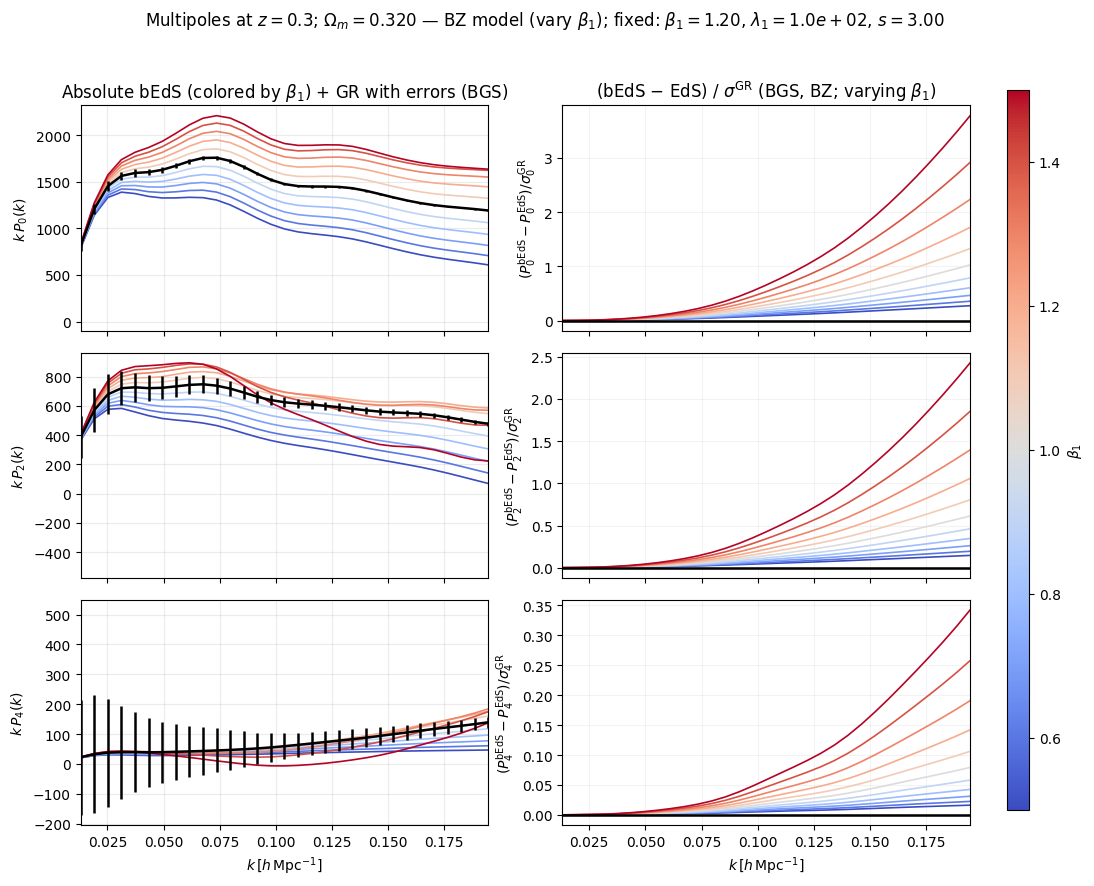

In [9]:
# 3×2 figure:
# col 0: absolute beyond-EdS multipoles (colored by chosen param) + GR in black WITH ERROR BARS
# col 1: significance = (bEdS − EdS) / σ_GR per multipole (colored by chosen param) + GR (zero line) in black

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm   # <-- for log color scale when sweeping s
from copy import deepcopy

# ---- pyfkpt (new fkpt wrapper) ----
import pyfkpt.rsd as pyfkpt

# ---- ISiTGR ----
import isitgr
from isitgr import model

# ---- thecov (Gaussian covariances of P_ell) ----
from thecov import geometry, covariance

# ==========================
# Configuration
# ==========================
h      = 0.6711
ombh2  = 0.022
omch2  = 0.122
omnuh2 = 0.0
As     = 2e-9
ns     = 0.965
z_pk   = 0.3

Om     = (ombh2 + omch2 + omnuh2) / (h**2)
print("Omega_m:", Om)

KMAX = 0.3
CAMB_KMAX = max(2.0, 16.0 * KMAX) * 1.25

# nuisance / bias
b1 = 1.70
b2 = -0.45
bs2  = -4/7*(b1 - 1)
b3nl = 32/315*(b1 - 1)
alpha0, alpha2, alpha4, ctilde = 3.0, -29.0, 0.0, 0.0
alpha0shot, alpha2shot, pshotp = 0.08, -8.0, 5000.0
nuis = [b1,b2,bs2,b3nl,alpha0,alpha2,alpha4,ctilde,alpha0shot,alpha2shot,pshotp]

# ==========================
# Choose which BZ parameter to sweep: 'beta1' | 'lambda1' | 's'
# ==========================
SWEEP_PARAM = 'beta1'  # <-- change as needed

# fixed/reference values when sweeping the others
fixed_beta1   = 1.2
fixed_lambda1 = 1e2
fixed_s       = 3.0

# Default linear/geometric ranges for beta1/lambda1; s handled specially below
default_ranges = {
    'beta1':   np.linspace(0.5, 1.5, 11),
    's': np.geomspace(1, 5, 11),
}

# Pretty symbols & formatters
def param_meta(name):
    if name == 'beta1':
        return r'\beta_1', r'$\beta_1$', lambda v: f"{v:.2f}"
    if name == 'lambda1':
        return r'\lambda_1', r'$\lambda_1$', lambda v: f"{v:.1e}"
    if name == 's':
        return r's', r'$s$', lambda v: f"{v:.2f}"
    raise ValueError("SWEEP_PARAM must be one of {'beta1','lambda1','s'}")

param_tex, param_tex_math, fmt = param_meta(SWEEP_PARAM)

# ---- Build sweep values and colormap normalizer ----
cmap = plt.get_cmap('coolwarm')

if SWEEP_PARAM == 'lambda1':
    # Your requested log-sweep with explicit zero:
    n_values = 10  # -> 9 positive log points + 1 zero = 10 total
    log_vals   = np.logspace(1, 3, n_values - 1)  # 10^1 .. 10^6 (9 pts)
    x_vals     = np.insert(log_vals, 0, 0.0)
    positives  = x_vals[x_vals > 0]
    norm       = LogNorm(vmin=positives.min(), vmax=positives.max())
else:
    x_vals = default_ranges[SWEEP_PARAM]
    norm   = mpl.colors.Normalize(vmin=x_vals.min(), vmax=x_vals.max())

# ---- BGS tracer settings for covariance ----
BGS_nbar   = 5.0e-4
BGS_volume = 2000.0**3

# k-range to display / use for σ
KMIN_MASK = 0.01
KMAX_MASK = 0.20

base_common = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    nquadSteps=300, chatty=0,
    model="HDKI",
    mg_variant="BZ",
)

# ==========================
# Helper: return EdS & bEdS multipoles for given BZ params
# ==========================
def compute_multipoles_pair(beta_1, lambda_1, exp_s):
    pars = isitgr.CAMBparams()
    pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, mnu=93.14*omnuh2,
                       MG_parameterization="mueta", use_BZ_form=True,
                       beta_1=beta_1, lambda_1=lambda_1, exp_s=exp_s)
    pars.InitPower.set_params(As=As, ns=ns)

    # tightly sample around z_pk for f(k,z)
    dln_a = 1e-3
    a0 = 1.0/(1.0 + z_pk)
    z1 = 1.0/(a0*np.exp(-dln_a)) - 1.0
    z2 = 1.0/(a0*np.exp(+dln_a)) - 1.0
    z_list = sorted([z1, z_pk, z2, 0.0])

    pars.set_matter_power(redshifts=z_list, kmax=CAMB_KMAX)
    pars.NonLinear = model.NonLinear_none
    results = isitgr.get_results(pars)

    PK, _, ks = results.get_matter_power_interpolator(
        nonlinear=False, hubble_units=True, k_hunit=True, return_z_k=True, silent=True
    )
    pk_lin = PK.P(z_pk, ks)
    kh_fk, fk_lin = results.f_of_k(z_pk, hubble_units=True, k_hunit=True)
    assert np.allclose(kh_fk, ks)

    mask   = ks <= KMAX
    ks_cut = ks[mask]
    pk_cut = pk_lin[mask]
    fk_cut = fk_lin[mask]

    smallk = ks_cut < 3e-3
    f0 = float(np.mean(fk_cut[smallk])) if np.any(smallk) else float(fk_cut[0])

    base = dict(
        **base_common,
        beta_1=beta_1,
        lambda_1=lambda_1,
        exp_s=exp_s,
        kmin=float(max(1e-3, ks_cut.min())),
        kmax=float(min(ks_cut.max(), KMAX)),
        Nk=int(min(ks_cut.size, 50)),
    )
    k_eval = np.linspace(base["kmin"], base["kmax"], base["Nk"])

    # EdS kernels
    pE = deepcopy(base); pE["rescale_PS"]=False; pE["use_beyond_eds_kernels"]=False
    tE = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **pE)
    kE, P0E, P2E, P4E = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tE)

    # beyond-EdS kernels
    pB = deepcopy(base); pB["rescale_PS"]=False; pB["use_beyond_eds_kernels"]=True
    tB = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **pB)
    kB, P0B, P2B, P4B = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tB)

    assert np.allclose(kE, kB)
    return kB, (P0E, P2E, P4E), (P0B, P2B, P4B)

def interp_to_grid(k_src, y_src, k_target):
    return np.interp(k_target, k_src, y_src)

def kwargs_for_value(param_name, x):
    if param_name == 'beta1':
        return dict(beta_1=x,           lambda_1=fixed_lambda1, exp_s=fixed_s)
    if param_name == 'lambda1':
        return dict(beta_1=fixed_beta1, lambda_1=x,             exp_s=fixed_s)
    if param_name == 's':
        return dict(beta_1=fixed_beta1, lambda_1=fixed_lambda1, exp_s=x)
    raise ValueError

# ================= plot: 3×2 grid =================
plt.close('all')
fig, axes = plt.subplots(3, 2, figsize=(11, 9), sharex='col')
(ax0_abs, ax0_sig), (ax2_abs, ax2_sig), (ax4_abs, ax4_sig) = axes

# colorbar axis
fig.subplots_adjust(right=0.90)
cax = fig.add_axes([0.92, 0.09, 0.02, 0.80])

# ScalarMappable for colorbar with the chosen norm
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k_for_cov = None
P0E_GR = P2E_GR = P4E_GR = None
P0B_GR = P2B_GR = P4B_GR = None

# ---------- GR baseline FIRST (β1=1.0; λ1=0; s=0) ----------
k_for_cov, (P0E_GR, P2E_GR, P4E_GR), (P0B_GR, P2B_GR, P4B_GR) = compute_multipoles_pair(
    beta_1=1.0, lambda_1=0.0, exp_s=0.0
)

# ---------- sweep (absolute curves, left column) ----------
for x_val in x_vals:
    k, (P0E, P2E, P4E), (P0B, P2B, P4B) = compute_multipoles_pair(**kwargs_for_value(SWEEP_PARAM, x_val))
    if SWEEP_PARAM == 'lambda1' and x_val == 0.0:
        color = 'gray'  # LogNorm is undefined at 0 — use a neutral color
    else:
        color = cmap(norm(x_val))
    ax0_abs.plot(k, k*P0B, color=color, lw=1.2)
    ax2_abs.plot(k, k*P2B, color=color, lw=1.2)
    ax4_abs.plot(k, k*P4B, color=color, lw=1.2)

# ---------- build covariance from GR (BGS tracer) ----------
Nk_full = k_for_cov.size
dk_full = (k_for_cov[-1] - k_for_cov[0]) / (Nk_full - 1)
kmin_edge_full = k_for_cov[0] - dk_full/2.0
kmax_edge_full = k_for_cov[-1] + dk_full/2.0

geom = geometry.BoxGeometry(volume=BGS_volume, nbar=BGS_nbar)
cov  = covariance.GaussianCovariance(geom)
cov.set_kbins(kmin=kmin_edge_full, kmax=kmax_edge_full, dk=dk_full)

cov.set_galaxy_pk_multipole(P0B_GR, ell=0, has_shotnoise=True)
cov.set_galaxy_pk_multipole(P2B_GR, ell=2)
cov.set_galaxy_pk_multipole(P4B_GR, ell=4)
cov.compute_covariance()

diag_full = np.sqrt(np.diag(cov.cov))
sig0_full = diag_full[0:Nk_full]
sig2_full = diag_full[Nk_full:2*Nk_full]
sig4_full = diag_full[2*Nk_full:3*Nk_full]

# ---------- apply k mask consistently ----------
mask_cov = (k_for_cov > KMIN_MASK) & (k_for_cov < KMAX_MASK)

k_for_cov = k_for_cov[mask_cov]
P0B_GR = P0B_GR[mask_cov]; P2B_GR = P2B_GR[mask_cov]; P4B_GR = P4B_GR[mask_cov]
P0E_GR = P0E_GR[mask_cov]; P2E_GR = P2E_GR[mask_cov]; P4E_GR = P4E_GR[mask_cov]
sig0_GR = sig0_full[mask_cov]; sig2_GR = sig2_full[mask_cov]; sig4_GR = sig4_full[mask_cov]

# ---------- GR with error bars (absolute column) ----------
ax0_abs.errorbar(k_for_cov, k_for_cov*P0B_GR, yerr=k_for_cov*sig0_GR, fmt='-', color='k', lw=1.8, capsize=0)
ax2_abs.errorbar(k_for_cov, k_for_cov*P2B_GR, yerr=k_for_cov*sig2_GR, fmt='-', color='k', lw=1.8, capsize=0)
ax4_abs.errorbar(k_for_cov, k_for_cov*P4B_GR, yerr=k_for_cov*sig4_GR, fmt='-', color='k', lw=1.8, capsize=0)

# ---------- significance (right column): (bEdS − EdS)/σ_GR ----------
for x_val in x_vals:
    k, (P0E, P2E, P4E), (P0B, P2B, P4B) = compute_multipoles_pair(**kwargs_for_value(SWEEP_PARAM, x_val))
    if SWEEP_PARAM == 's' and x_val == 0.0:
        color = 'gray'
    else:
        color = cmap(norm(x_val))

    d0 = P0B - P0E
    d2 = P2B - P2E
    d4 = P4B - P4E

    d0_on_cov = interp_to_grid(k, d0, k_for_cov)
    d2_on_cov = interp_to_grid(k, d2, k_for_cov)
    d4_on_cov = interp_to_grid(k, d4, k_for_cov)

    s0 = d0_on_cov / sig0_GR
    s2 = d2_on_cov / sig2_GR
    s4 = d4_on_cov / sig4_GR

    ax0_sig.plot(k_for_cov, s0, color=color, lw=1.2)
    ax2_sig.plot(k_for_cov, s2, color=color, lw=1.2)
    ax4_sig.plot(k_for_cov, s4, color=color, lw=1.2)

# GR reference zero line
ax0_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)
ax2_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)
ax4_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)

# ----- styling -----
for ax, lab in zip([ax0_abs, ax2_abs, ax4_abs],
                   [r"$k\,P_0(k)$", r"$k\,P_2(k)$", r"$k\,P_4(k)$"]):
    ax.grid(True, alpha=0.25)
    ax.set_ylabel(lab)

for ax, lab in zip([ax0_sig, ax2_sig, ax4_sig],
                   [r"$(P_0^{\rm bEdS}-P_0^{\rm EdS})/\sigma_0^{\rm GR}$",
                    r"$(P_2^{\rm bEdS}-P_2^{\rm EdS})/\sigma_2^{\rm GR}$",
                    r"$(P_4^{\rm bEdS}-P_4^{\rm EdS})/\sigma_4^{\rm GR}$"]):
    ax.axhline(0, color='k', lw=1.0, alpha=0.5)
    ax.grid(True, alpha=0.15)
    ax.set_ylabel(lab)

for col in range(2):
    for ax in axes[:, col]:
        ax.set_xlim(k_for_cov[0], k_for_cov[-1])
for ax in axes[-1, :]:
    ax.set_xlabel(r"$k\,[h\,\mathrm{Mpc}^{-1}]$")

# Titles & colorbar
axes[0,0].set_title(fr"Absolute bEdS (colored by {param_tex_math}) + GR with errors (BGS)", fontsize=12)
axes[0,1].set_title(fr"(bEdS − EdS) / $\sigma^{{\rm GR}}$ (BGS, BZ; varying {param_tex_math})", fontsize=12)

cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(param_tex_math)

fixed_desc = fr"$\beta_1={fixed_beta1:.2f}$, $\lambda_1={fixed_lambda1:.1e}$, $s={fixed_s:.2f}$"
fig.suptitle(fr"Multipoles at $z={z_pk}$; $\Omega_m={Om:.3f}$ — BZ model (vary {param_tex_math}); fixed: {fixed_desc}",
             y=0.98)

plt.tight_layout(rect=[0, 0, 0.90, 0.96])
plt.show()
